# EXECUTIVE SUMMARY

**Introduction:** The Consumer Finance Protection Bureau (CFPB) is an independent agency of the United States government dedicated to providing protection to consumers from financial institutions [1](https://www.consumerfinance.gov/). Aggrieved consumers can submit complaints to the CFPB who redirects it to the responsible companies. The consumer can then either accept or dispute the company response. In this project, we aimed to predict whether a consumer will dispute a response from a financial institution from the information about the complaint published on the database.

**Possible Contributions:** The possible contributions of the project benefit both the companies and consumers. Since the complaints and company names are public, it hurts a company's image to have too many disputes on the database. By predicting those complaints that might be disputed later by the consumer, companies can take a closer look or an alternative approach to respond to such issues. From a consumer standpoint, they should watch out for certain types of financial products as they lead to more disputes.  

**Dataset Description:** The dataset was downloaded from the following website [2](https://www.kaggle.com/datasets/kaggle/us-consumer-finance-complaints). The dataset contained 555957 rows and 17 columns. The features describing the complaints included: date when the complaint was submitted, company name,  type of financial product, type of issue, consumer complaint description, company response, customer location and time taken by company to respond. The output feature that we want to predict is whether the consumer disputes the company response to the complaint or not (Yes = 1, No = 0). This was a classification problem.

**Exploratory Data Analysis**: We created boxplots and piecharts during EDA and found that:
  * Wells Fargo and Bank of America had the top most consumer complaints,
  * Citibank responses had higher than usual disputes among customers.
  * Mortgage, debt collection and credit reporting had the most number of issues faced by consumers.
  * Most complaints originated from California, Florida, Texas, New York and Georgia.
  * Shorter response times by CFPB correlate with more disputes.

**Pre-processing (Data Cleaning):** We first removed the `column _complaint_id` since it contained no valuable information.

**Pre-processing (Missing Values):** We pre-processed the dataset by first filling in missing values. For example, the feature zipcode had incomplete values such as '300XX'. For this feature, we looked at the most frequently occuring complete zipcode starting with '300' which was '30058'. For other features where values were missing at random, we used the most frequent value to replace missing values.

**Pre-processing (Feature Engineering):** We created new useful features from the existing dataset. We converted zipcode to latitudes and longitudes using a library called `pgeocode` [3](https://pypi.org/project/pgeocode/) because they are continuous and numerical. They also allow us to create only 2 new columns instead of 26,000 new columns for each zipcode. We extracted the month and year of complaint as well as days taken by CFPB to send the complaint to the company as separate features. Lastly, there was a column containing consumer complaint narratives in the form of unstructured text. We used a pre-trained sentiment analysis language model to convert text into sentiment scores (negative and neutral) and used that as a proxy for complaint narrative [4](https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment).

**Modeling:** After normalizing the numerical features and converting the categorical features into numerical using dummy encoding, we moved on to model building. In total, we had 4022 features. The dataset had class imbalance: Yes (disputed) = 20%, No (not disputed) = 80%. We split the dataset into training (80%), validation (10%) and test set (10%) in a stratified manner, i.e., maintaining the same imbalanced distribution of the output column in the train and test set. Furthermore, we used the random undersampling method to resample our training set so that it contained equal distribution of class 1 and class 0 observations (89,669 cases for each).

Since we were handling Big Data and a large number of columns contained zeros, we converted our dataset into a sparse matrix. This drastically reduced our data size and computation time. We then tested several ML algorithms: Logistic Regression, Support Vector Classifier, Random Forest, XGBoost and MLP classifier. For each of these models, we used grid search 5-fold cross validation to find the best performing model. We obtained the following mean ROC AUC scores across the 5 cross validation folds:
  * Logistic Regression: 0.634,
  * Support Vector Classifier: 0.633,
  * XG Boost: 0.643,
  * Random Forest: 0.613
  * MLP: 0.630

We selected the XG Boost classifier as our final model since it had the best score (effective) and low computation time (efficient). Next, we did a more refined grid search to optimize this model. We then trained it on the entire, balanced training set and tested it on the imbalanced test set. We obtained the following scores:

  Test set: Class 0: 44340, Class 1: 11256, Probability threshold = 0.5

  * Precision: 0.26
  * Recall: 0.71
  * F1-score: 0.39
  * ROC AUC: 0.65

We also used contigency tables and chi-square test and Mann Whitney U test to find out important features. We found that company response to consumers and response time of CFPB were features that distinguished between consumers who disputed vs. those who didn't with statistical significance.

**Key Takeaways:**
1. We predicted the disputed cases with a 71% rate (recall). We consider this as a success since now we can predict a large number of complaints which will lead to disputes and therefore companies can take preemptive meausures.  
2. We could only modestly predict the company response to consumer complaints that were disputed (ROC AUC = 0.65). A likely reason for that is close to 80% cases in the dataset containing missing information in columns such as: `consumer_consent_provided`, `company_public_response`, `tags` and `consumer_complaint_narrative`.  
3. Another likely reason for low signal in the dataset could be the lack of features that better distinguish between the two classes. Some additional features that can be helpful but are missing in the dataset would be:
  * _The monetary amount in dollars that is part of the complaint:_ The hypothesis is that more the amount of money involved, the more likely that the consumer might dispute the response.
  * _The monetary amount that the company compensates the consumer:_ The hypothesis being if the compensation is not close to what the consumer seeks in return, more likely that the response will be disputed.
  * _Demographic Information:_ The dataset did not provide any demographic information about the consumers such as their age, sex, race, marital status, occupation, etc.
  *_Credit Worthiness:_ Since most of the products complained about were related to credit in the form of mortgage, student loan, etc., it would have been useful if the dataset contained credit scores of the consumers.        
4. Companies such as Wells Fargo, Bank of America and Citibank have the most complaints from consumers. From a company standpoint, these companies should be either more selective in offering products and/or find alternative ways to respond to consumer complaints. As a consumer, one could look at other banks as they do offer similar products.
5. Company response is correlated with company disputes. Better explanation from companies, more monetary relief and alternative ways to compensate consumers can lead to less disputes.
6. Shorter response time (difference between the date the complaint is received by CFPB from consumers and sent by CFPB to companies) correlates with more disputes. The CFPB can investigate to find out why this is the case.   

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install pgeocode wordcloud xgboost imblearn category-encoders

In [ ]:
# Data Loading
import pandas as pd
import pickle

# data wrangling
from collections import Counter
import numpy as np
# feature engineering
from datetime import date
import pgeocode
import time

# data visualization
import matplotlib.pyplot as plt
%matplotlib inline
from wordcloud import WordCloud
import plotly.express as px
import seaborn as sns
from matplotlib.pyplot import figure

# model building
from scipy.stats import ttest_ind, chi2_contingency
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV
from scipy.stats import chi2_contingency, mannwhitneyu
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from scipy import sparse
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve, make_scorer
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.neural_network import MLPClassifier
from scipy import stats
from sklearn import metrics

In [ ]:
get_cwd = '/content/drive/MyDrive/DATA6400/project'

# DATA LOADING

In [ ]:
consumer_complaint_df = pd.read_csv(f'{get_cwd}/consumer_complaints.csv', low_memory=False)
consumer_complaint_df.drop(columns=['complaint_id'], inplace=True)
consumer_complaint_df.head()

,date_received,product,sub_product,issue,sub_issue,consumer_complaint_narrative,company_public_response,company,state,zipcode,tags,consumer_consent_provided,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed?
0,08/30/2013,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,U.S. Bancorp,CA,95993,NaN,NaN,Referral,09/03/2013,Closed with explanation,Yes,Yes
1,08/30/2013,Mortgage,Other mortgage,"Loan servicing, payments, escrow account",NaN,NaN,NaN,Wells Fargo & Company,CA,91104,NaN,NaN,Referral,09/03/2013,Closed with explanation,Yes,Yes
2,08/30/2013,Credit reporting,NaN,Incorrect information on credit report,Account status,NaN,NaN,Wells Fargo & Company,NY,11764,NaN,NaN,Postal mail,09/18/2013,Closed with explanation,Yes,No
3,08/30/2013,Student loan,Non-federal student loan,Repaying your loan,Repaying your loan,NaN,NaN,"Navient Solutions, Inc.",MD,21402,NaN,NaN,Email,08/30/2013,Closed with explanation,Yes,Yes
4,08/30/2013,Debt collection,Credit card,False statements or representation,Attempted to collect wrong amount,NaN,NaN,Resurgent Capital Services L.P.,GA,30106,NaN,NaN,Web,08/30/2013,Closed with explanation,Yes,Yes


# EXPLORATORY DATA ANALYSIS

In this section, we do a quick exploration of the features in the dataset. The dataset has more than half a million rows and 17 columns. Most of the features are categorical including textual features such as the complaint description from the customer. Timestamp features include the date the complaint was submitted to the CFPB and the date when CFPB submitted the complaint to the appropriate financial institution.

### KEY OBSERVATIONS

1. DISPUTE RATE: The dataset is imbalanced with around 20% of customers disputing the company response. We'll handle this later using imbalanced learning for predictive modeling.

2. COMPANY:

  *  Wells Fargo and Bank of America had the top most consumer complaints.

  *  Citibank is amongst the top 5 companies for which consumers disputed the company response. However, they are not amongst the top 5 companies for which the consumers who didn't dispute their response. This might suggest that Citibank responses had higher than usual disputes among customers.

3. COMPANY RESPONSE TO CONSUMER: We found that amongst the non-disputed responses, 72.5% of the responses had explanations. On the other hand, amongst the disputed respnses, 81.2% had explanations. One would have expected the opposite trend: company responses without explanations would have had more disputes.

4. PRODUCT: Mortgage, debt collection and credit reporting had the most number of issues faced by consumers.
  * Mortgage had a 7% higher dispute rate compared to customers who didn't.
  * Conventional fixed mortgage had a 6% higher dispute rate.
  * Credit reporting had a 4.2% lower dispute rate.

5. ISSUES: Most of the issues were related to loan modification/collection/foreclosure, incorrect information on credit report and loan servicing/payments/escrow account.
  * Loan modification had a 5% higher dispute rate.

6. LOCATION: Most complaints originated from the most populous states in the US: California, Florida, Texas, New York and Georgia.

7. CONSENT: The rate of customers who provided consent was higher in the customers who disputed by 5.5%.

8. METHOD OF SUBMISSION: Most complaints were submitted using the internet. However, customers who disputed had a higher submission (7.5%) through the web.

In [ ]:
print('shape of dataset =', f'{consumer_complaint_df.shape}')

shape of dataset = (555957, 17)


In [ ]:
consumer_complaint_df.dtypes

,0
date_received,object
product,object
sub_product,object
issue,object
sub_issue,object
consumer_complaint_narrative,object
company_public_response,object
company,object
state,object
zipcode,object


In [ ]:
feat = 'consumer_complaint_narrative'
consumer_complaint_df.loc[consumer_complaint_df[feat] == consumer_complaint_df[feat], feat].head()

,consumer_complaint_narrative
190126,XXXX has claimed I owe them {$27.00} for XXXX ...
190135,Due to inconsistencies in the amount owed that...
190155,In XX/XX/XXXX my wages that I earned at my job...
190207,I have an open and current mortgage with Chase...
190208,XXXX was submitted XX/XX/XXXX. At the time I s...


In [ ]:
financial_products = consumer_complaint_df['product']
financial_products_dict = Counter(financial_products)

In [ ]:
word_could_dict=Counter(financial_products_dict)
wordcloud = WordCloud(width = 1000, height = 500,background_color='white').generate_from_frequencies(word_could_dict)

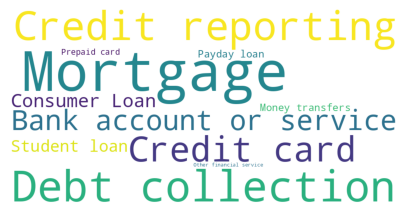

In [ ]:
plt.figure(figsize=(5,5))
plt.imshow(wordcloud)
plt.axis("off")
plt.savefig(f'{get_cwd}/products.png', bbox_inches='tight')
plt.show()
plt.close()

In [ ]:
issues = consumer_complaint_df['issue']
issues_dict = Counter(issues)

In [ ]:
word_could_dict=Counter(issues_dict)
wordcloud = WordCloud(width = 1000, height = 800,background_color='white').generate_from_frequencies(word_could_dict)

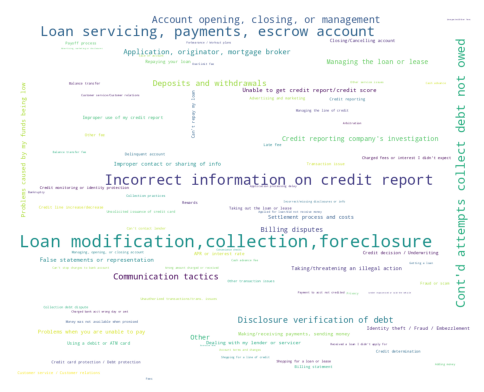

In [ ]:
plt.figure(figsize=(6,6))
plt.imshow(wordcloud)
plt.axis("off")
plt.savefig(f'{get_cwd}/issues.png', bbox_inches='tight')
plt.show()
plt.close()

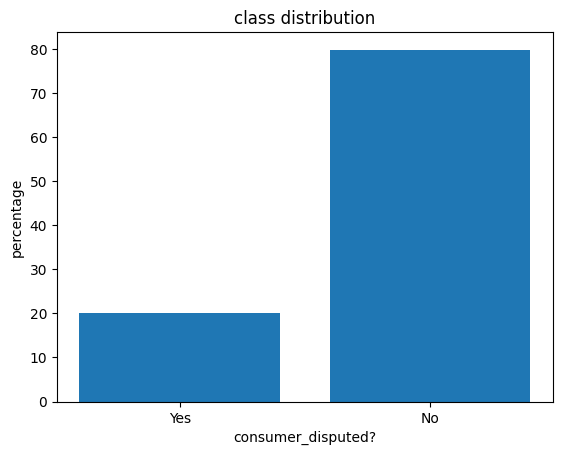

In [ ]:
class_count_dict = Counter(consumer_complaint_df['consumer_disputed?'].values)
plt.bar(['Yes', 'No'], [class_count_dict['Yes']*100/consumer_complaint_df.shape[0], class_count_dict['No']*100/consumer_complaint_df.shape[0]])
plt.xlabel('consumer_disputed?')
plt.ylabel('percentage')
plt.title('class distribution');

In [ ]:
disputed_yes_df = consumer_complaint_df.loc[consumer_complaint_df['consumer_disputed?'] == 'Yes']
disputed_no_df = consumer_complaint_df.loc[consumer_complaint_df['consumer_disputed?'] == 'No']

In [ ]:
def pieplot(df0, df1, col, df_0_title, df_1_title, lim=5, yname=None):

    '''
    This function makes a pie chart for the Spark dataframe df
    for categorical column col only selecting top categories
    as specified by lim.
    '''

    # Grouping by the categories, counting on each categories
    # and ordering them by the count
    classes0 = df0.groupby(col).size().reset_index(name='count').sort_values(by='count', ascending=False)
    classes1 = df1.groupby(col).size().reset_index(name='count').sort_values(by='count', ascending=False)

    # Take first 'lim' number of rows and convert to pandas
    pd_df0 = classes0[:lim]
    pd_df1 = classes1[:lim]
    # Making plot
    fig, axs = plt.subplots(1, 2)
    pd_df0.plot(kind='pie', x=col, y='count', title = f'{col}\n {df_0_title}',\
           labels=pd_df0[col], legend=None, autopct='%1.1f%%', \
          explode=[j*0.1 for j in range(pd_df0.shape[0])], figsize=(10,10), ax = axs[0])
    pd_df1.plot(kind='pie', x=col, y='count', title = f'{col}\n {df_1_title}',\
           labels=pd_df1[col], legend=None, autopct='%1.1f%%', \
          explode=[j*0.1 for j in range(pd_df1.shape[0])], figsize=(10,10), ax = axs[1])
    plt.ylabel(None)
    plt.show()

In [ ]:
columns = list(consumer_complaint_df.columns)
columns.remove('consumer_disputed?')
columns

['date_received',
 'product',
 'sub_product',
 'issue',
 'sub_issue',
 'consumer_complaint_narrative',
 'company_public_response',
 'company',
 'state',
 'zipcode',
 'tags',
 'consumer_consent_provided',
 'submitted_via',
 'date_sent_to_company',
 'company_response_to_consumer',
 'timely_response']

In [ ]:
categorical_columns = columns.copy()
categorical_columns.remove('date_received')
categorical_columns.remove('consumer_complaint_narrative')
categorical_columns.remove('company_public_response')
categorical_columns.remove('zipcode')
categorical_columns.remove('date_sent_to_company')
categorical_columns

['product',
 'sub_product',
 'issue',
 'sub_issue',
 'company',
 'state',
 'tags',
 'consumer_consent_provided',
 'submitted_via',
 'company_response_to_consumer',
 'timely_response']

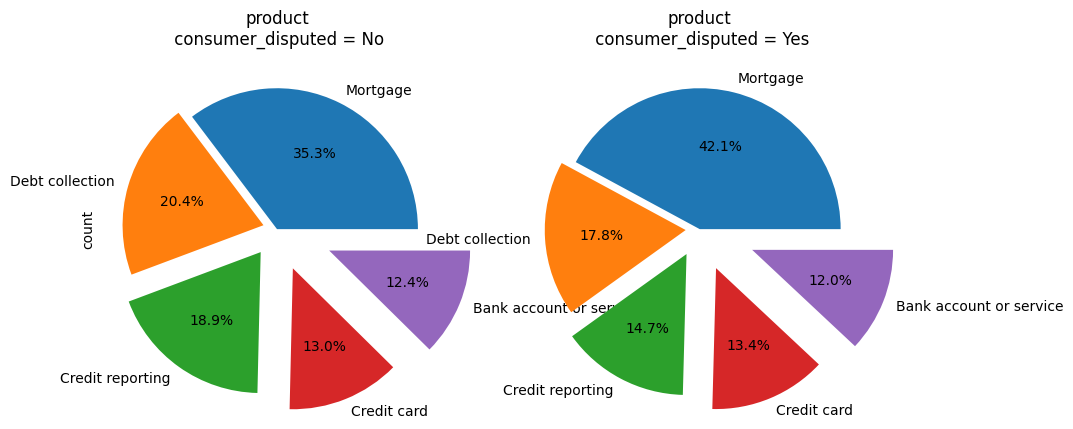

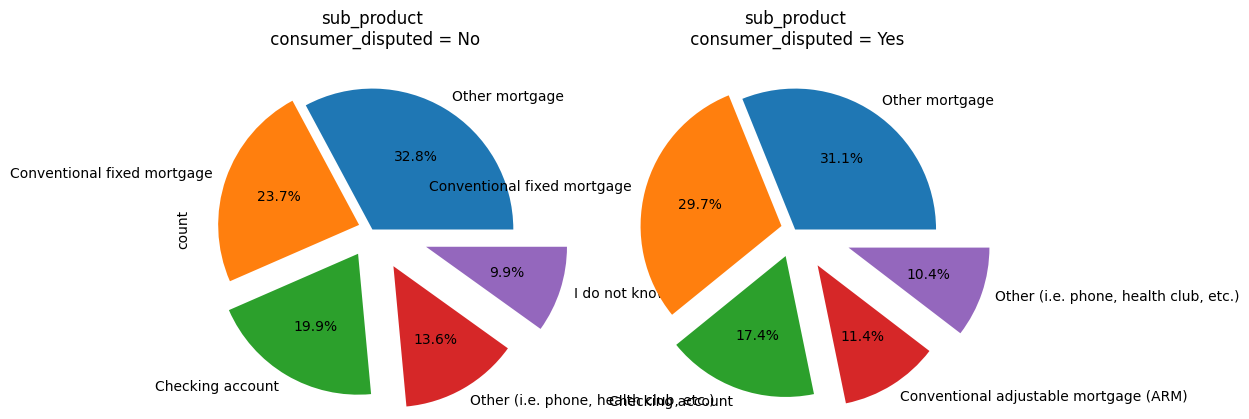

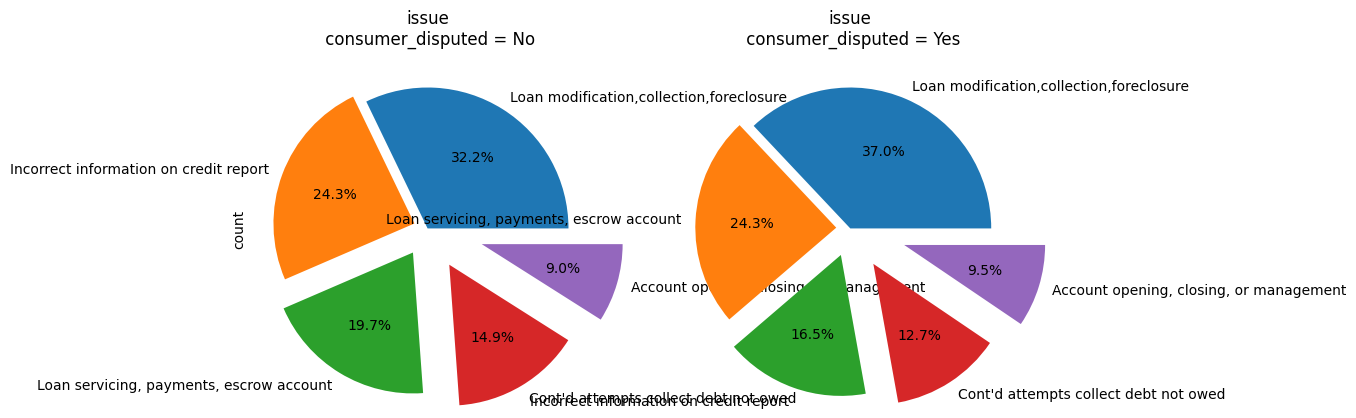

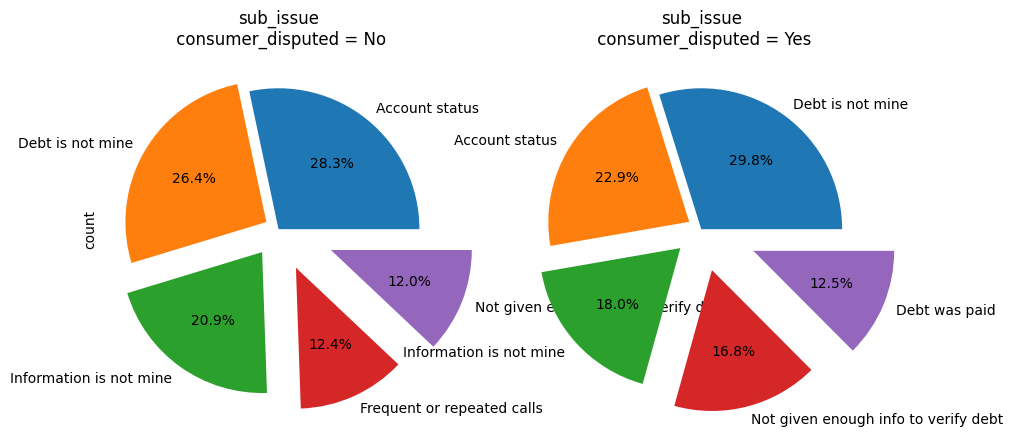

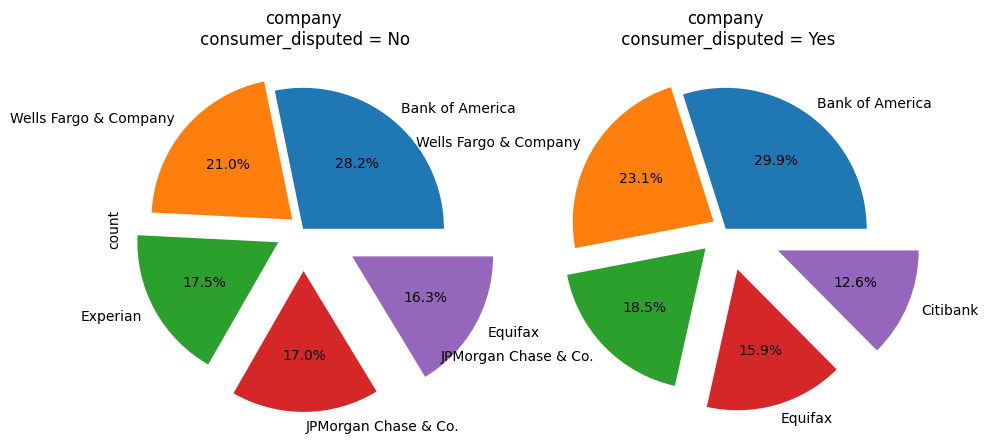

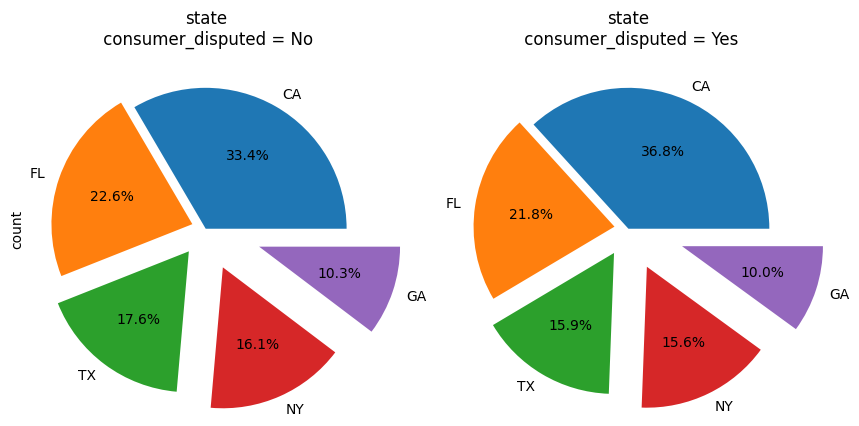

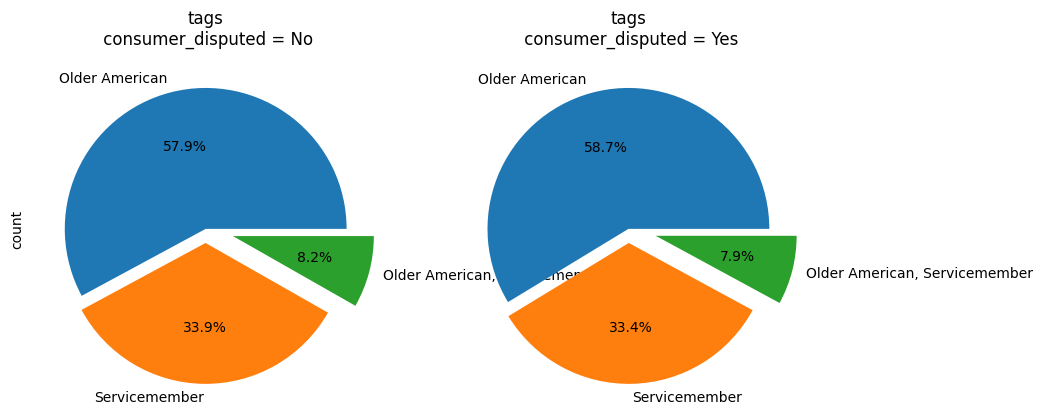

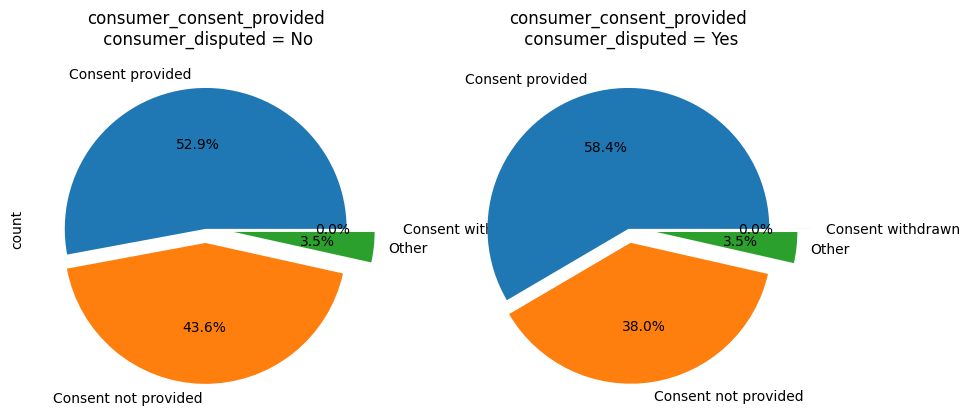

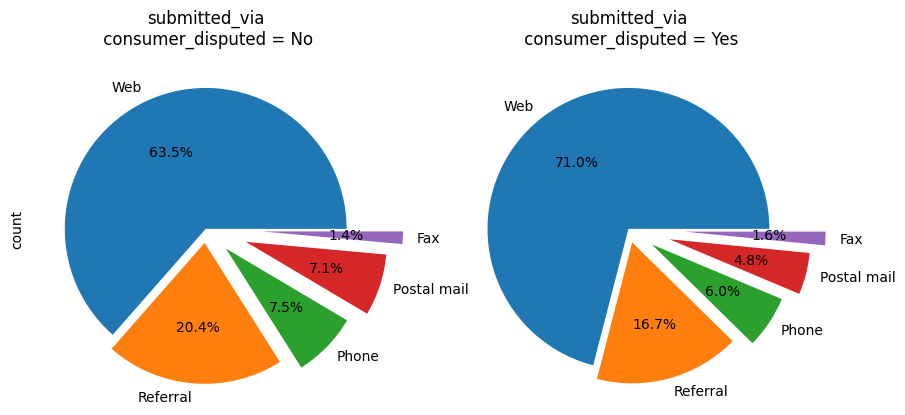

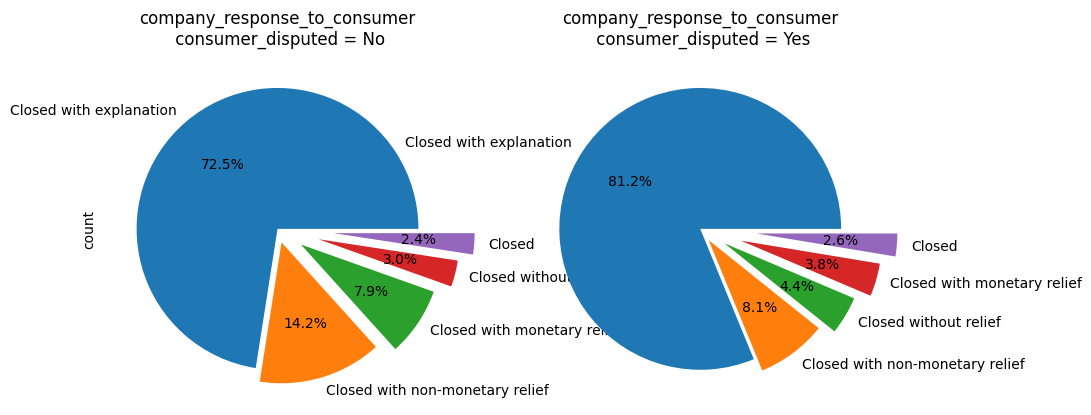

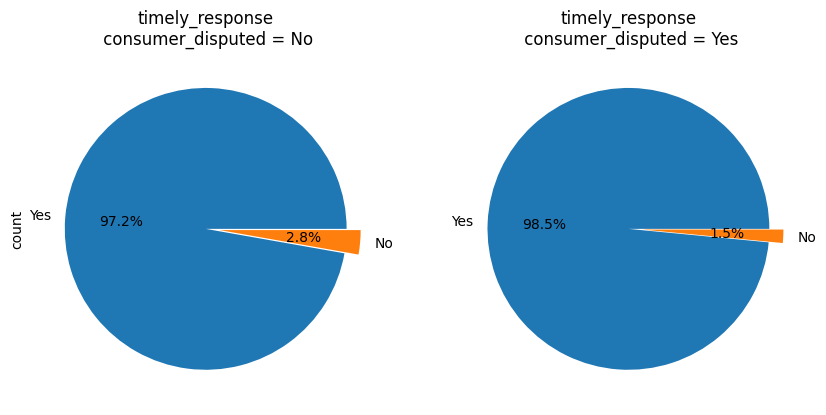

In [ ]:
for col in categorical_columns:
  pieplot(disputed_no_df, disputed_yes_df, col, 'consumer_disputed = No', 'consumer_disputed = Yes')

In [ ]:
# Creating a test train split using a test size of 0.2 i.e. 20 percent of the dataset
train, test = train_test_split(consumer_complaint_df, test_size=0.1, random_state = 1)

# DATA PRE-PROCESSING

In this section, we replace incomplete and missing values in the dataset. Incomplete values are completed using the existing information in the value. Missing values are either replaced using information from other columns or the most frequent value of the column.

Later in the section, we also engineer new features such as converting zipcodes to latitudes and longitudes, converting text to sentiment, etc. This helps us use the categorical and textual information in our dataset more efficiently.  

## Incomplete Values

The zipcode column in the dataset contains 77470 incomplete values such as '300XX' where the first few digits of the value are available. For such cases, we replace '300XX' with the most frequent zipcode in the dataset starting with '300'.

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 500361 entries, 251824 to 128037
Data columns (total 17 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   date_received                 500361 non-null  object
 1   product                       500361 non-null  object
 2   sub_product                   357826 non-null  object
 3   issue                         500361 non-null  object
 4   sub_issue                     191411 non-null  object
 5   consumer_complaint_narrative  60223 non-null   object
 6   company_public_response       76676 non-null   object
 7   company                       500361 non-null  object
 8   state                         495961 non-null  object
 9   zipcode                       496305 non-null  object
 10  tags                          70259 non-null   object
 11  consumer_consent_provided     111153 non-null  object
 12  submitted_via                 500361 non-null  object
 13 

In [ ]:
def cols_with_missing_vals_list(df):
  # Looking for columns with missing values
  columns_with_missing_vals = []

  # Iterate over each column in the training dataframe
  for col in df.columns:
      # Count the number of missing values in the column
      num_missing_vals = df[col].isna().sum()
      # Check if the column has any missing values
      if num_missing_vals > 0:
        # if so, append column in list of columns with missing values
        columns_with_missing_vals.append((col, num_missing_vals))
  columns_with_missing_vals = sorted(columns_with_missing_vals, key = lambda x: x[1])
  print('column name, number of missing values, percentage of missing values\n')
  for column in columns_with_missing_vals:
    print(f'{column[0]}, {column[1]}, {round(100*column[1]/df.shape[0], 3)}')
  return columns_with_missing_vals

In [ ]:
columns_with_missing_vals = cols_with_missing_vals_list(train)

column name, number of missing values, percentage of missing values

zipcode, 4056, 0.811
state, 4400, 0.879
sub_product, 142535, 28.486
sub_issue, 308950, 61.745
consumer_consent_provided, 389208, 77.785
company_public_response, 423685, 84.676
tags, 430102, 85.958
consumer_complaint_narrative, 440138, 87.964


In [ ]:
# Loop through each column in the dataframe with missing values and print the corresponding statistics
i = iter(range(len(columns_with_missing_vals)))

In [ ]:
# Looking at first column in the list with missing values
col = columns_with_missing_vals[next(i)]
print(col)

('zipcode', np.int64(4056))


In [ ]:
# looking at categories
categories = Counter(train[col[0]])
[(key, value) for key, value in sorted(categories.items(), key = lambda x: x[1], reverse=True)][:10]

[(nan, 4056),
 ('300XX', 1088),
 ('48382', 834),
 ('750XX', 811),
 ('900XX', 771),
 ('331XX', 771),
 ('770XX', 762),
 ('945XX', 731),
 ('606XX', 687),
 ('330XX', 684)]

**Key observation:** We notice that there are 4056 entries with no information about the zipcode. Apart from that, there are also entries with partial zipcode information.

In [ ]:
zip_xx = {key: categories[key] for key in categories.keys() if key == key and 'XX' in key}
sorted(zip_xx .items(), key = lambda x: x[1], reverse=True)[:10]

[('300XX', 1088),
 ('750XX', 811),
 ('900XX', 771),
 ('331XX', 771),
 ('770XX', 762),
 ('945XX', 731),
 ('606XX', 687),
 ('330XX', 684),
 ('891XX', 643),
 ('207XX', 619)]

In [ ]:
zip_valid = {key: categories[key] for key in categories.keys() if key == key and 'XX' not in key}
sorted(zip_valid .items(), key = lambda x: x[1], reverse=True)[:10]

[('48382', 834),
 ('33071', 564),
 ('33173', 437),
 ('76116', 348),
 ('20774', 308),
 ('92101', 302),
 ('20744', 301),
 ('30349', 292),
 ('92626', 289),
 ('11375', 282)]

In [ ]:
print('Number of entries with incomplete zipcodes:', sum(zip_xx.values()))

Number of entries with incomplete zipcodes: 69858


In [ ]:
print('incomplete zipcodes =', len(zip_xx))

incomplete zipcodes = 915


**Key Step:** We complete the incomplete zipcode values in the following way. For eg., let's look at the zipcode 300XX. We find that in the dataset, the most frequent, complete zipcode beginning with 300 was 30058. Therefore, we replace 300XX with 30058.

In [ ]:
def most_populated_zipcode_func(first_3_digits, zipcode_dict):
  candidate_zipcodes = {key: zipcode_dict[key] for key in zipcode_dict.keys() if str(key[0:3]) == first_3_digits}
  if candidate_zipcodes == {}:
    return first_3_digits+'00'
  most_populated_zip = sorted(candidate_zipcodes.items(), key = lambda x: x[1], reverse = True)[0][0]
  return most_populated_zip

In [ ]:
zip_xx_to_valid = {}
special_chars = [' ', '[', '*', '+', '.', '`']
unknown_zips = []
for key in zip_xx.keys():
  unknown_zips = [key for char in special_chars if char in key]
  if key not in unknown_zips:
    most_populated_zip = most_populated_zipcode_func(key[0:3], zip_valid)
    zip_xx_to_valid[key] = most_populated_zip

In [ ]:
def impute_zipcode(df):
    zipcode_values = df[col[0]].values
    # iterating over all rows in dataframe
    new_zipcode_values = []
    for index, zipcode in enumerate(zipcode_values):
        # Check if the value is missing
        if zipcode in zip_xx_to_valid.keys():
          new_zipcode_values.append(zip_xx_to_valid[zipcode])
        else:
          new_zipcode_values.append(zipcode)
    return new_zipcode_values

In [ ]:
train[col[0]] = impute_zipcode(train)
test[col[0]] = impute_zipcode(test)

In [ ]:
assert 'XX' not in train[col[0]].values
assert 'XX' not in test[col[0]].values

In [ ]:
assert unknown_zips not in list(train[col[0]].values)
assert unknown_zips not in list(test[col[0]].values)

## Missing Values

Even though columns such as `consumer_consent_provided`, `company_public_response`, `tags` and `consumer_complaint_narrative` have close to or more than 80% missing values, we will not drop these columns since the dataset has very few features. Instead, we will replace the missing values with 'value_unknown'. For the rest of the columns: `sub_issue`, `sub_product`, `state` and `zipcode`, we will discuss how we imputed missing values below.

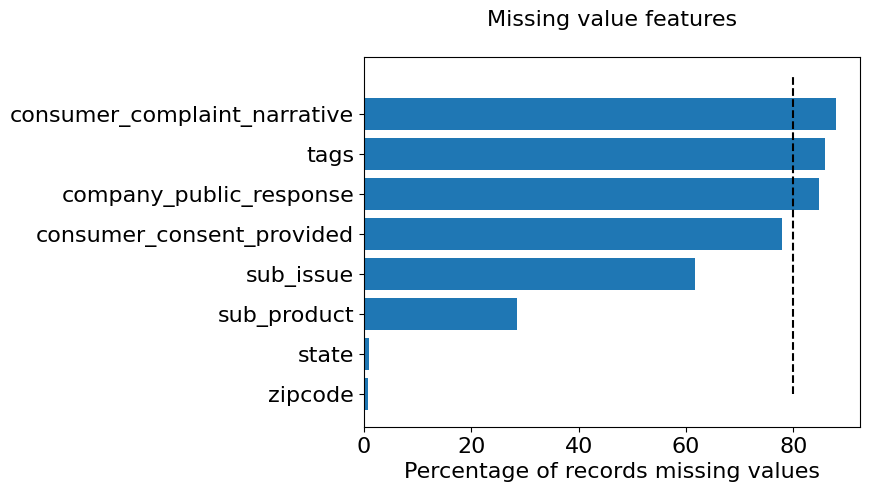

In [ ]:
# Calculate the percentage of missing values for each column
columns_with_missing_vals_percentage = [100*ent[1]/train.shape[0] for ent in columns_with_missing_vals]

# Plot a horizontal bar chart showing the percentage of missing values for each feature
fontsize = 16
# plt.figure(figsize=(10,10))
plt.barh([ent[0] for ent in columns_with_missing_vals], columns_with_missing_vals_percentage)
plt.vlines(80,0,len(columns_with_missing_vals), ls = '--', color = 'black')
plt.xlabel('Percentage of records missing values', fontsize = fontsize)
plt.title('Missing value features\n', fontsize = fontsize)
plt.yticks(fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.savefig(get_cwd + '/missing_values.png');

### Zipcode

In [ ]:
# looking at categories
categories = Counter(train[col[0]].values)
[(key, value) for key, value in sorted(categories.items(), key = lambda x: x[1], reverse=True)][:10]

[(nan, 4056),
 ('30058', 1345),
 ('33071', 1248),
 ('33173', 1208),
 ('90046', 1044),
 ('48382', 1044),
 ('75052', 1032),
 ('77065', 997),
 ('20774', 927),
 ('94565', 895)]

**Key step:** Now, let's fill in the missing zipcode values. Let's try to fill them using the state information for these entries.

In [ ]:
df = train.loc[train[col[0]] != train[col[0]]]['state']
df.head()

,state
471932,NaN
482155,NaN
492683,NaN
119054,NaN
366408,NaN


In [ ]:
df.loc[df != df].shape

(4047,)

**Key insight:** We see that most missing zipcode entries have missing state information too. Therefore, let's replace the missing zipcode values with the most frequent zipcode 90046 in the most frequent state, CA.

In [ ]:
most_frequent_state = sorted(Counter(train['state']).items(), key = lambda x: x[1], reverse=True)[0]
print(f'(Most frequent state, count) = {most_frequent_state}')

(Most frequent state, count) = ('CA', 73685)


In [ ]:
train_most_freq_state_df = train.loc[train['state'] == most_frequent_state[0]]
print(f'(most frequent zipcodes in {most_frequent_state[0]}, count)')
sorted(Counter(train_most_freq_state_df['zipcode']).items(), key = lambda x: x[1], reverse=True)[:5]

(most frequent zipcodes in CA, count)


[('90046', 1043),
 ('94565', 892),
 ('92626', 822),
 ('91730', 723),
 ('92101', 722)]

In [ ]:
most_populated_zipcode = sorted(Counter(train_most_freq_state_df['zipcode']).items(), key = lambda x: x[1], reverse=True)[0]
most_populated_zipcode

('90046', 1043)

In [ ]:
train.loc[train[col[0]] != train[col[0]], col[0]] = most_populated_zipcode[0]
test.loc[test[col[0]] != test[col[0]], col[0]] = most_populated_zipcode[0]

In [ ]:
assert train[col[0]].isna().sum() == 0
assert test[col[0]].isna().sum() == 0

### State

**Key Step:** Now let's look at the state column. For missing state values, we used the postal code to infer the state.

In [ ]:
# Looking at first column in the list with missing values
col = columns_with_missing_vals[next(i)]
print(col[0])

state


In [ ]:
print('Number of missing state values = ', train.loc[train[col[0]] != train[col[0]]].shape[0])

Number of missing state values =  4400


In [ ]:
def postal_code_to_state(postal_code):
  '''
  returns the state code from zipcode
  '''
  country_list = ['us', 'pr', 'vi', 'gu', 'as']
  index = 0
  state_code = np.nan
  while state_code != state_code and index < len(country_list):
    nomi = pgeocode.Nominatim(country_list[index])
    state_code = nomi.query_postal_code(postal_code)['state_code']
    index += 1
  return state_code

In [ ]:
def impute_state(df, postal_code_state_dict):
    state_list = []
    zipcode_list = df['zipcode'].values

    for index, state in enumerate(df[col[0]].values):
      if state != state:
        zipcode = zipcode_list[index]
        if zipcode in postal_code_state_dict.keys():
          state = postal_code_state_dict[zipcode]
        else:
          state = postal_code_to_state(zipcode)
          postal_code_state_dict[zipcode] = state
      state_list.append(state)
    return state_list, postal_code_state_dict

In [ ]:
train[col[0]], postal_code_state_dict = impute_state(train, {})
test[col[0]], _ = impute_state(test, postal_code_state_dict)

In [ ]:
print('Number of rows with missing state:', train[col[0]].isna().sum())

Number of rows with missing state: 4


In [ ]:
train.loc[train[col[0]] != train[col[0]], col[0]] = most_frequent_state[0]
test.loc[test[col[0]] != test[col[0]], col[0]] = most_frequent_state[0]

In [ ]:
assert train[col[0]].isna().sum() == 0
assert test[col[0]].isna().sum() == 0

### Sub-product

In [ ]:
# Looking at the next column in the list with missing values
col = columns_with_missing_vals[next(i)]
print(col)

('sub_product', np.int64(142535))


In [ ]:
# looking at categories
categories = Counter(train[col[0]].values)
# print(len(categories))
[(key, value) for key, value in sorted(categories.items(), key = lambda x: x[1], reverse=True)][:10]

[(nan, 142535),
 ('Other mortgage', 66950),
 ('Conventional fixed mortgage', 51330),
 ('Checking account', 39918),
 ('Other (i.e. phone, health club, etc.)', 26658),
 ('I do not know', 19462),
 ('Conventional adjustable mortgage (ARM)', 18856),
 ('Credit card', 18757),
 ('FHA mortgage', 17283),
 ('Non-federal student loan', 16212)]

**Key Step:** For missing sub-products, we looked at the products for such entries. We found that only products named credit reporting and credit cards had missing sub-products. Therefore, we'll create new sub-products named with the same product name for the missing sub-products.

In [ ]:
Counter(train.loc[train[col[0]] != train[col[0]]]['product'])

Counter({'Credit reporting': 82656, 'Credit card': 59879})

In [ ]:
sub_product_nan_product_dict = Counter(train.loc[train[col[0]] != train[col[0]]]['product'])
assert sum(sub_product_nan_product_dict.values()) == categories[np.nan]

In [ ]:
print('Number of missing values:', categories[np.nan])
print('Missing sub-products with credit reporting and credit card as products:', Counter(train['product'])['Credit reporting'] + Counter(train['product'])['Credit card'])

Number of missing values: 142535
Missing sub-products with credit reporting and credit card as products: 142535


In [ ]:
train.loc[(train[col[0]] != train[col[0]]) & (train['product'] == 'Credit reporting'), col[0]] = 'Credit reporting - credit reporting'
train.loc[(train[col[0]] != train[col[0]]) & (train['product'] == 'Credit card'), col[0]] = 'Credit card - credit card'

test.loc[(test[col[0]] != test[col[0]]) & (test['product'] == 'Credit reporting'), col[0]] = 'Credit reporting - credit reporting'
test.loc[(test[col[0]] != test[col[0]]) & (test['product'] == 'Credit card'), col[0]] = 'Credit card - credit card'

In [ ]:
assert train[col[0]].isna().sum() == 0
assert test[col[0]].isna().sum() == 0

### Sub-issue

In [ ]:
# Looking at the next column in the list with missing values
col = columns_with_missing_vals[next(i)]
print(col)

('sub_issue', np.int64(308950))


In [ ]:
# looking at categories
categories = Counter(train[col[0]].values)
# print(len(categories))
[(key, value) for key, value in sorted(categories.items(), key = lambda x: x[1], reverse=True)][:10]

[(nan, 308950),
 ('Account status', 24118),
 ('Debt is not mine', 23595),
 ('Information is not mine', 17875),
 ('Not given enough info to verify debt', 11250),
 ('Debt was paid', 10233),
 ('Frequent or repeated calls', 10209),
 ('Account terms', 6550),
 ('Attempted to collect wrong amount', 5682),
 ('Public record', 4996)]

In [ ]:
sub_issue_nan_issue_dict = Counter(train.loc[train[col[0]] != train[col[0]]]['issue'])
sorted(sub_issue_nan_issue_dict.items(), key = lambda x: x[1], reverse=True)[:10]

[('Loan modification,collection,foreclosure', 87555),
 ('Loan servicing, payments, escrow account', 54160),
 ('Account opening, closing, or management', 24000),
 ('Deposits and withdrawals', 15446),
 ('Application, originator, mortgage broker', 11972),
 ('Billing disputes', 9950),
 ('Other', 9743),
 ('Managing the loan or lease', 8965),
 ('Problems caused by my funds being low', 8163),
 ('Settlement process and costs', 6182)]

In [ ]:
issue_dict = Counter(train['issue'])
sorted(issue_dict.items(), key = lambda x: x[1], reverse=True)[:20]

[('Loan modification,collection,foreclosure', 87555),
 ('Incorrect information on credit report', 60023),
 ('Loan servicing, payments, escrow account', 54160),
 ("Cont'd attempts collect debt not owed", 38054),
 ('Account opening, closing, or management', 24000),
 ('Communication tactics', 16477),
 ('Disclosure verification of debt', 16461),
 ('Deposits and withdrawals', 15446),
 ('Application, originator, mortgage broker', 11972),
 ('Billing disputes', 9950),
 ('Other', 9743),
 ("Credit reporting company's investigation", 9442),
 ('Managing the loan or lease', 8965),
 ('Problems caused by my funds being low', 8163),
 ('False statements or representation', 7460),
 ('Unable to get credit report/credit score', 7321),
 ('Improper contact or sharing of info', 6693),
 ('Problems when you are unable to pay', 6184),
 ('Settlement process and costs', 6182),
 ('Taking/threatening an illegal action', 5858)]

**Key Step:** For missing sub-issues, we looked at the issues and found that certain issues like: Loan modification/collection/foreclosure, Loan servicing/ payments/escrow account, etc. had sub-issues missing for all entries. Therefore, we'll replace the missing sub-issue values with the corresponding issue value.

In [ ]:
issue_list = []
for issue, count in sorted(sub_issue_nan_issue_dict.items(), key = lambda x: x[1], reverse = True):
  issue_total_count = issue_dict[issue]
  if count/issue_total_count >= 0.95:
    issue_list.append(issue)
  else: print(f'{issue}, Missing issue count: {count}, Total issue count: {issue_total_count}, ratio: {round(count/issue_total_count,2)}')


Problems when you are unable to pay, Missing issue count: 4623, Total issue count: 6184, ratio: 0.75
Charged fees or interest I didn't expect, Missing issue count: 169, Total issue count: 1720, ratio: 0.1
Can't contact lender, Missing issue count: 45, Total issue count: 663, ratio: 0.07
Payment to acct not credited, Missing issue count: 42, Total issue count: 271, ratio: 0.15
Applied for loan/did not receive money, Missing issue count: 21, Total issue count: 255, ratio: 0.08
Received a loan I didn't apply for, Missing issue count: 11, Total issue count: 377, ratio: 0.03
Can't stop charges to bank account, Missing issue count: 5, Total issue count: 306, ratio: 0.02
Charged bank acct wrong day or amt, Missing issue count: 3, Total issue count: 176, ratio: 0.02


For some issues, not all sub-issues were empty. However, there were very few such cases. So we continued with replacing the missing sub-issue with the corresponding issue for these cases as well.

In [ ]:
def impute_sub_issue(df):
    for index, row in df.iterrows():
        # Check if the value is missing
        if row[col[0]] != row[col[0]]:
        # Get the diagnosis 1 code
          issue = row['issue']
          df.at[index, col[0]] = issue
    return df

In [ ]:
train = impute_sub_issue(train)
test = impute_sub_issue(test)

In [ ]:
assert train[col[0]].isna().sum() == 0
assert test[col[0]].isna().sum() == 0

### Consumer consent

In [ ]:
# Looking at the next column in the list with missing values
col = columns_with_missing_vals[next(i)]
print(col)

('consumer_consent_provided', np.int64(389208))


In [ ]:
# looking at categories
categories = Counter(train[col[0]].values)
# print(len(categories))
[(key, value) for key, value in sorted(categories.items(), key = lambda x: x[1], reverse=True)][:10]

[(nan, 389208),
 ('Consent provided', 60224),
 ('Consent not provided', 47036),
 ('Other', 3890),
 ('Consent withdrawn', 3)]

**Key Step:** For company public response, 85% of the values were missing. Since we have only few columns in the dataset, dropping this feature entirely can lead to more bias during predictive modeling. Instead, let's fill in the missing values with 'Consent Unknown'.

In [ ]:
train.loc[train[col[0]] != train[col[0]] , col[0]] = 'Consent unknown'
test.loc[test[col[0]] != test[col[0]] , col[0]] = 'Consent unknown'

In [ ]:
assert train[col[0]].isna().sum() == 0
assert test[col[0]].isna().sum() == 0

### Company public response

In [ ]:
# Looking at the next column in the list with missing values
col = columns_with_missing_vals[next(i)]
print(col)

('company_public_response', np.int64(423685))


In [ ]:
# looking at categories
categories = Counter(train[col[0]].values)
# print(len(categories))
[(key, value) for key, value in sorted(categories.items(), key = lambda x: x[1], reverse=True)][:5]

[(nan, 423685),
 ('Company chooses not to provide a public response', 47274),
 ('Company believes it acted appropriately as authorized by contract or law',
  13842),
 ('Company has responded to the consumer and the CFPB and chooses not to provide a public response',
  9411),
 ('Company believes complaint caused principally by actions of third party outside the control or direction of the company',
  1347)]

**Key Step:** For missing company response, we added 'Company response unknown' instead of dropping this column.

In [ ]:
train.loc[train[col[0]] != train[col[0]], col[0]] = 'Company response unknown'
test.loc[test[col[0]] != test[col[0]], col[0]] = 'Company response unknown'

In [ ]:
assert train[col[0]].isna().sum() == 0
assert test[col[0]].isna().sum() == 0

### Tags

In [ ]:
# Looking at the next column in the list with missing values
col = columns_with_missing_vals[next(i)]
print(col)

('tags', np.int64(430102))


In [ ]:
# looking at categories
categories = Counter(train[col[0]].values)
# print(len(categories))
[(key, value) for key, value in sorted(categories.items(), key = lambda x: x[1], reverse=True)][:10]

[(nan, 430102),
 ('Older American', 40779),
 ('Servicemember', 23750),
 ('Older American, Servicemember', 5730)]

**Key Step:** For missing Tag, we added 'Tag unknown' instead of dropping this column.

In [ ]:
train.loc[train[col[0]] != train[col[0]], col[0]] = 'Tag unknown'
test.loc[test[col[0]] != test[col[0]], col[0]] = 'Tag unknown'

In [ ]:
assert train[col[0]].isna().sum() == 0
assert test[col[0]].isna().sum() == 0

In [ ]:
# Looking at the next column in the list with missing values
col = columns_with_missing_vals[next(i)]
print(col)

('consumer_complaint_narrative', np.int64(440138))


**Key Step:** For missing consumer complaint narrative, we added 'Consumer complaint narrative unknown' for the time being instead of dropping this column.

In [ ]:
train.loc[train[col[0]] != train[col[0]], col[0]] = 'Consumer complaint narrative unknown'
test.loc[test[col[0]] != test[col[0]], col[0]] = 'Consumer complaint narrative unknown'

In [ ]:
assert train[col[0]].isna().sum() == 0
assert test[col[0]].isna().sum() == 0

In [ ]:
train.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 500361 entries, 251824 to 128037
Data columns (total 17 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   date_received                 500361 non-null  object
 1   product                       500361 non-null  object
 2   sub_product                   500361 non-null  object
 3   issue                         500361 non-null  object
 4   sub_issue                     500361 non-null  object
 5   consumer_complaint_narrative  500361 non-null  object
 6   company_public_response       500361 non-null  object
 7   company                       500361 non-null  object
 8   state                         500361 non-null  object
 9   zipcode                       500361 non-null  object
 10  tags                          500361 non-null  object
 11  consumer_consent_provided     500361 non-null  object
 12  submitted_via                 500361 non-null  object
 13 

In [ ]:
test.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 55596 entries, 334801 to 23711
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   date_received                 55596 non-null  object
 1   product                       55596 non-null  object
 2   sub_product                   55596 non-null  object
 3   issue                         55596 non-null  object
 4   sub_issue                     55596 non-null  object
 5   consumer_complaint_narrative  55596 non-null  object
 6   company_public_response       55596 non-null  object
 7   company                       55596 non-null  object
 8   state                         55596 non-null  object
 9   zipcode                       55596 non-null  object
 10  tags                          55596 non-null  object
 11  consumer_consent_provided     55596 non-null  object
 12  submitted_via                 55596 non-null  object
 13  date_sent_to_com

# FEATURE ENGINEERING

In this section, we create new spatial, temporal and sentiment score features from existing ones so that we can use the information more efficiently.

### Temporal Features

Let's extract some temporal features such as number of days between the consumer sending their complaint to CFPB and CFPB sending it to the company, month and year of the complaint received and sent by the CFPB. The hypothesis here is that the exact date of the complaint may not be relevant. However, in the US financial calender, the first quarter, i.e., January to April, is a tax filing period and therefore a period of heightened financial awareness from consumers and companies alike. One could expect more complaints and disputes during this time of the year.

The response time by CFPB could also be an important feature as delays from their end could make consumers unhappy.

In [ ]:
def date_diff(date_received, date_sent_to_company):
  '''
  returns the number of days between the date_received and date_sent_to_company
  '''
  date_received_date = date(int(date_received.split('/')[2]), int(date_received.split('/')[0]), int(date_received.split('/')[1]))
  date_sent_to_company_date = date(int(date_sent_to_company.split('/')[2]), int(date_sent_to_company.split('/')[0]), int(date_sent_to_company.split('/')[1]))
  time_diff = date_sent_to_company_date - date_received_date
  return time_diff.days

In [ ]:
date_received_list = train['date_received'].values
date_sent_to_company_list = train['date_sent_to_company'].values
response_time_list = [date_diff(date_received, date_sent_to_company_list[ind]) for ind, date_received in enumerate(date_received_list)]

In [ ]:
train['response_time_in_days'] = response_time_list

In [ ]:
month_received_list = [date_received.split('/')[0] for date_received in date_received_list]
train['month_received'] = month_received_list

month_sent_list = [date_sent.split('/')[0] for date_sent in date_sent_to_company_list]
train['month_sent'] = month_sent_list

In [ ]:
year_received_list = [date_received.split('/')[2] for date_received in date_received_list]
train['year_received'] = year_received_list

year_sent_list = [date_sent.split('/')[2] for date_sent in date_sent_to_company_list]
train['year_sent'] = year_sent_list

In [ ]:
date_received_list = test['date_received'].values
date_sent_to_company_list = test['date_sent_to_company'].values
response_time_list = [date_diff(date_received, date_sent_to_company_list[ind]) for ind, date_received in enumerate(date_received_list)]

test['response_time_in_days'] = response_time_list

In [ ]:
month_received_list = [date_received.split('/')[0] for date_received in date_received_list]
test['month_received'] = month_received_list

month_sent_list = [date_sent.split('/')[0] for date_sent in date_sent_to_company_list]
test['month_sent'] = month_sent_list

In [ ]:
year_received_list = [date_received.split('/')[2] for date_received in date_received_list]
test['year_received'] = year_received_list

year_sent_list = [date_sent.split('/')[2] for date_sent in date_sent_to_company_list]
test['year_sent'] = year_sent_list

In [ ]:
train.head()

,date_received,product,sub_product,issue,sub_issue,consumer_complaint_narrative,company_public_response,company,state,zipcode,...,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed?,response_time_in_days,month_received,month_sent,year_received,year_sent
251824,07/01/2015,Credit reporting,Credit reporting - credit reporting,Incorrect information on credit report,Information is not mine,On my report there is another XXXX XXXX living...,Company chooses not to provide a public response,Experian,OH,44646,...,Web,07/01/2015,Closed with non-monetary relief,Yes,No,0,07,07,2015,2015
305134,10/15/2015,Credit reporting,Credit reporting - credit reporting,Improper use of my credit report,Report improperly shared by CRC,"While checking my personal credit report, I di...",Company chooses not to provide a public response,Experian,WA,98374,...,Web,10/15/2015,Closed with explanation,Yes,No,0,10,10,2015,2015
33818,02/21/2014,Debt collection,"Other (i.e. phone, health club, etc.)",Cont'd attempts collect debt not owed,Debt is not mine,Consumer complaint narrative unknown,Company response unknown,Resurgent Capital Services L.P.,VA,23452,...,Fax,02/24/2014,Closed with explanation,Yes,No,3,02,02,2014,2014
176436,12/30/2014,Debt collection,Medical,Improper contact or sharing of info,Contacted me after I asked not to,Consumer complaint narrative unknown,Company response unknown,"Retrieval-Masters Creditors Bureau, Inc.",NY,10065,...,Web,12/30/2014,Closed,Yes,No,0,12,12,2014,2014
204034,03/17/2015,Mortgage,Other mortgage,Other,Other,Consumer complaint narrative unknown,Company response unknown,PNC Bank N.A.,TX,75035,...,Referral,03/23/2015,Closed,Yes,No,6,03,03,2015,2015


### Spatial Features

The total number of unique zipcodes in the dataset is 26417. This would create as many new columns during dummy encoding the zipcode column. Adding too many dimensions can create issues with having too many dimensions in the dataset. It will also increase the size of the dataset and training time. Furthermore, zipcode values cannot be treated as numerical values because as seen in the map below, zipcodes starting with 60-62 are closer in distance to 46-47 but the ones with 50-52 are further away. Therefore, numerically they are not continuous.   

<img src="https://upload.wikimedia.org/wikipedia/commons/2/24/ZIP_Code_zones.svg" alt="drawing" width="500"/>

Instead of using the raw zipcode, we use the `pgeocode` library in Python to convert all zipcode values to latitude and longitude. Doing so has the advantage that it'll create only 2 new numerical columns. The values are also continuous.


In [ ]:
print('number of zipcodes:', len(Counter(train['zipcode'])))

number of zipcodes: 25489


In [ ]:
def postal_code_to_location(df, country, feature_name, output_filename):
  '''
  returns the latitude and longitude values from zipcodes and saves them to a csv file
  '''
  nomi = pgeocode.Nominatim(country)
  zipcode_list = list(df[feature_name].values)
  start = time.time()
  lat_long_df = nomi.query_postal_code(zipcode_list)
  end = time.time()
  print('Time taken:', round((end - start), 2), 'seconds')
  lat_long_df.to_csv(output_filename)

In [ ]:
for country in ['us', 'pr', 'vi', 'gu', 'as']:
  output_filename = f'{get_cwd}/train_lat_long_{country}.csv'
  postal_code_to_location(train, country, 'zipcode', output_filename) # zipcodes from mainland US

Time taken: 0.17 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.18 seconds
Time taken: 0.19 seconds


In [ ]:
lat_long_us_df = pd.read_csv(f'{get_cwd}/train_lat_long_us.csv')
lat_long_us_df.drop(columns=['Unnamed: 0'], inplace=True)
lat_long_us_df.tail()

,postal_code,country_code,place_name,state_name,state_code,county_name,county_code,community_name,community_code,latitude,longitude,accuracy
500356,46808,US,Fort Wayne,Indiana,IN,Allen,3.0,NaN,NaN,41.0939,-85.1621,4.0
500357,11590,US,Westbury,New York,NY,Nassau,59.0,NaN,NaN,40.7557,-73.5723,4.0
500358,07460,US,Stockholm,New Jersey,NJ,Sussex,37.0,NaN,NaN,41.0992,-74.5283,4.0
500359,90807,US,Long Beach,California,CA,Los Angeles,37.0,NaN,NaN,33.8315,-118.1811,4.0
500360,80207,US,Denver,Colorado,CO,Denver,31.0,NaN,NaN,39.7584,-104.9177,4.0


In [ ]:
lat_long_pr_df = pd.read_csv(f'{get_cwd}/train_lat_long_pr.csv')
lat_long_pr_df.drop(columns=['Unnamed: 0'], inplace=True)
lat_long_pr_df.tail()

,postal_code,country_code,place_name,state_name,state_code,county_name,county_code,community_name,community_code,latitude,longitude,accuracy
500356,46808,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
500357,11590,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
500358,07460,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
500359,90807,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
500360,80207,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
lat_long_vi_df = pd.read_csv(f'{get_cwd}/train_lat_long_vi.csv')
lat_long_vi_df.drop(columns=['Unnamed: 0'], inplace=True)
lat_long_vi_df.tail()

,postal_code,country_code,place_name,state_name,state_code,county_name,county_code,community_name,community_code,latitude,longitude,accuracy
500356,46808,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
500357,11590,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
500358,07460,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
500359,90807,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
500360,80207,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
lat_long_gu_df = pd.read_csv(f'{get_cwd}/train_lat_long_gu.csv')
lat_long_gu_df.drop(columns=['Unnamed: 0'], inplace=True)
lat_long_gu_df.tail()

,postal_code,country_code,place_name,state_name,state_code,county_name,county_code,community_name,community_code,latitude,longitude,accuracy
500356,46808,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
500357,11590,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
500358,07460,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
500359,90807,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
500360,80207,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
lat_long_as_df = pd.read_csv(f'{get_cwd}/train_lat_long_as.csv')
lat_long_as_df.drop(columns=['Unnamed: 0'], inplace=True)
lat_long_as_df.tail()

<ipython-input-217-11bda2399200>:1: DtypeWarning: Columns (2,3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  lat_long_as_df = pd.read_csv(f'{get_cwd}/train_lat_long_as.csv')


,postal_code,country_code,place_name,state_name,state_code,county_name,county_code,community_name,community_code,latitude,longitude,accuracy
500356,46808,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
500357,11590,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
500358,07460,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
500359,90807,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
500360,80207,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
us_latitudes = lat_long_us_df['latitude'].values
us_longitudes = lat_long_us_df['longitude'].values

pr_latitudes = lat_long_pr_df['latitude'].values
pr_longitudes = lat_long_pr_df['longitude'].values

vi_latitudes = lat_long_vi_df['latitude'].values
vi_longitudes = lat_long_vi_df['longitude'].values

gu_latitudes = lat_long_gu_df['latitude'].values
gu_longitudes = lat_long_gu_df['longitude'].values

as_latitudes = lat_long_as_df['latitude'].values
as_longitudes = lat_long_as_df['longitude'].values

In [ ]:
latitudes = [np.nanmax(ent_tuple) for ent_tuple in zip(us_latitudes, pr_latitudes, vi_latitudes, gu_latitudes, as_latitudes)]
longitudes = [np.nanmax(ent_tuple) for ent_tuple in zip(us_longitudes, pr_longitudes, vi_longitudes, gu_longitudes, as_longitudes)]

<ipython-input-219-50b5547efd3c>:1: RuntimeWarning: All-NaN axis encountered
  latitudes = [np.nanmax(ent_tuple) for ent_tuple in zip(us_latitudes, pr_latitudes, vi_latitudes, gu_latitudes, as_latitudes)]
<ipython-input-219-50b5547efd3c>:2: RuntimeWarning: All-NaN axis encountered
  longitudes = [np.nanmax(ent_tuple) for ent_tuple in zip(us_longitudes, pr_longitudes, vi_longitudes, gu_longitudes, as_longitudes)]


In [ ]:
train['latitude'] = latitudes
train['longitude'] = longitudes

In [ ]:
train.head()

,date_received,product,sub_product,issue,sub_issue,consumer_complaint_narrative,company_public_response,company,state,zipcode,...,company_response_to_consumer,timely_response,consumer_disputed?,response_time_in_days,month_received,month_sent,year_received,year_sent,latitude,longitude
251824,07/01/2015,Credit reporting,Credit reporting - credit reporting,Incorrect information on credit report,Information is not mine,On my report there is another XXXX XXXX living...,Company chooses not to provide a public response,Experian,OH,44646,...,Closed with non-monetary relief,Yes,No,0,07,07,2015,2015,40.8116,-81.4973
305134,10/15/2015,Credit reporting,Credit reporting - credit reporting,Improper use of my credit report,Report improperly shared by CRC,"While checking my personal credit report, I di...",Company chooses not to provide a public response,Experian,WA,98374,...,Closed with explanation,Yes,No,0,10,10,2015,2015,47.1424,-122.2652
33818,02/21/2014,Debt collection,"Other (i.e. phone, health club, etc.)",Cont'd attempts collect debt not owed,Debt is not mine,Consumer complaint narrative unknown,Company response unknown,Resurgent Capital Services L.P.,VA,23452,...,Closed with explanation,Yes,No,3,02,02,2014,2014,36.8348,-76.0961
176436,12/30/2014,Debt collection,Medical,Improper contact or sharing of info,Contacted me after I asked not to,Consumer complaint narrative unknown,Company response unknown,"Retrieval-Masters Creditors Bureau, Inc.",NY,10065,...,Closed,Yes,No,0,12,12,2014,2014,40.7651,-73.9638
204034,03/17/2015,Mortgage,Other mortgage,Other,Other,Consumer complaint narrative unknown,Company response unknown,PNC Bank N.A.,TX,75035,...,Closed,Yes,No,6,03,03,2015,2015,33.1377,-96.7524


In [ ]:
train.loc[train['zipcode'].isin(['96950', '96951', '96952']), 'latitude'] = 15.0979 # Northern Marina Island
train.loc[train['zipcode'].isin(['96950', '96951', '96952']), 'longitude'] = 145.6739 # Northern Marina Island

In [ ]:
train.loc[train['latitude'] != train['latitude']].shape

(1334, 24)

In [ ]:
def sort_dict(d):
    '''
    this function sorts dictionaries based on their values.
    Args:
        d: dictionary
    '''
    return sorted(d.items(), key = lambda x: x[1], reverse = True)

In [ ]:
def impute_lat_long(state):
  lat_long_most_freq_state = train.loc[train['state'] == state, ['latitude', 'longitude']].mode().values[0]
  return lat_long_most_freq_state[0], lat_long_most_freq_state[1]

In [ ]:
for index, row in train.iterrows():
  if row['latitude'] != row['latitude']:
    state = row['state']
    latitude, longitude = impute_lat_long(state)
    train.at[index, 'latitude'] = latitude
    train.at[index, 'longitude'] = longitude

In [ ]:
assert train.loc[train['latitude'] != train['latitude']].shape[0] == 0

In [ ]:
for country in ['us', 'pr', 'vi', 'gu', 'as']:
  output_filename = f'{get_cwd}/test_lat_long_{country}.csv'
  postal_code_to_location(test, country, 'zipcode', output_filename) # zipcodes from mainland US

Time taken: 0.03 seconds
Time taken: 0.02 seconds
Time taken: 0.02 seconds
Time taken: 0.02 seconds
Time taken: 0.02 seconds


In [ ]:
lat_long_us_df = pd.read_csv(f'{get_cwd}/test_lat_long_us.csv')
lat_long_us_df.drop(columns=['Unnamed: 0'], inplace=True)
lat_long_us_df.tail()

,postal_code,country_code,place_name,state_name,state_code,county_name,county_code,community_name,community_code,latitude,longitude,accuracy
55591,32119,US,Daytona Beach,Florida,FL,Volusia,127.0,NaN,NaN,29.1600,-81.0269,4.0
55592,12414,US,Catskill,New York,NY,Greene,39.0,NaN,NaN,42.2276,-73.8985,4.0
55593,28027,US,Concord,North Carolina,NC,Cabarrus,25.0,NaN,NaN,35.4141,-80.6162,4.0
55594,99025,US,Newman Lake,Washington,WA,Spokane,63.0,NaN,NaN,47.7274,-117.0640,4.0
55595,79424,US,Lubbock,Texas,TX,Lubbock,303.0,NaN,NaN,33.5159,-101.9344,4.0


In [ ]:
lat_long_pr_df = pd.read_csv(f'{get_cwd}/test_lat_long_pr.csv')
lat_long_vi_df = pd.read_csv(f'{get_cwd}/test_lat_long_vi.csv')
lat_long_gu_df = pd.read_csv(f'{get_cwd}/test_lat_long_gu.csv')
lat_long_as_df = pd.read_csv(f'{get_cwd}/test_lat_long_as.csv')

In [ ]:
us_latitudes = lat_long_us_df['latitude'].values
us_longitudes = lat_long_us_df['longitude'].values

pr_latitudes = lat_long_pr_df['latitude'].values
pr_longitudes = lat_long_pr_df['longitude'].values

vi_latitudes = lat_long_vi_df['latitude'].values
vi_longitudes = lat_long_vi_df['longitude'].values

gu_latitudes = lat_long_gu_df['latitude'].values
gu_longitudes = lat_long_gu_df['longitude'].values

as_latitudes = lat_long_as_df['latitude'].values
as_longitudes = lat_long_as_df['longitude'].values

In [ ]:
latitudes = [np.nanmax(ent_tuple) for ent_tuple in zip(us_latitudes, pr_latitudes, vi_latitudes, gu_latitudes, as_latitudes)]
longitudes = [np.nanmax(ent_tuple) for ent_tuple in zip(us_longitudes, pr_longitudes, vi_longitudes, gu_longitudes, as_longitudes)]

<ipython-input-265-50b5547efd3c>:1: RuntimeWarning: All-NaN axis encountered
  latitudes = [np.nanmax(ent_tuple) for ent_tuple in zip(us_latitudes, pr_latitudes, vi_latitudes, gu_latitudes, as_latitudes)]
<ipython-input-265-50b5547efd3c>:2: RuntimeWarning: All-NaN axis encountered
  longitudes = [np.nanmax(ent_tuple) for ent_tuple in zip(us_longitudes, pr_longitudes, vi_longitudes, gu_longitudes, as_longitudes)]


In [ ]:
test['latitude'] = latitudes
test['longitude'] = longitudes

In [ ]:
test.loc[test['zipcode'].isin(['96950', '96951', '96952']), 'latitude'] = 15.0979 # Northern Marina Island
test.loc[test['zipcode'].isin(['96950', '96951', '96952']), 'longitude'] = 145.6739 # Northern Marina Island

In [ ]:
test.loc[test['latitude'] != test['latitude']].shape

(173, 24)

In [ ]:
for index, row in test.iterrows():
  if row['latitude'] != row['latitude']:
    state = row['state']
    latitude, longitude = impute_lat_long(state)
    test.at[index, 'latitude'] = latitude
    test.at[index, 'longitude'] = longitude

In [ ]:
assert test.loc[test['latitude'] != test['latitude']].shape[0] == 0

In [ ]:
train.drop(columns=['date_received', 'date_sent_to_company', 'zipcode'], inplace=True)

In [ ]:
train.tail()

,product,sub_product,issue,sub_issue,consumer_complaint_narrative,company_public_response,company,state,tags,consumer_consent_provided,...,company_response_to_consumer,timely_response,consumer_disputed?,response_time_in_days,month_received,month_sent,year_received,year_sent,latitude,longitude
371403,Bank account or service,Checking account,Problems caused by my funds being low,Problems caused by my funds being low,Consumer complaint narrative unknown,Company response unknown,Wells Fargo & Company,IN,Tag unknown,Consent unknown,...,Closed with explanation,Yes,No,2,07,07,2013,2013,41.0939,-85.1621
491263,Mortgage,Conventional fixed mortgage,"Loan modification,collection,foreclosure","Loan modification,collection,foreclosure",Consumer complaint narrative unknown,Company believes it acted appropriately as aut...,Ditech Financial LLC,NY,Tag unknown,Consent not provided,...,Closed with explanation,Yes,No,0,02,02,2016,2016,40.7557,-73.5723
470924,Mortgage,Conventional fixed mortgage,"Loan servicing, payments, escrow account","Loan servicing, payments, escrow account",Consumer complaint narrative unknown,Company response unknown,Loan Care,NJ,Tag unknown,Consent unknown,...,Closed with explanation,No,No,2,05,05,2013,2013,41.0992,-74.5283
491755,Credit reporting,Credit reporting - credit reporting,Incorrect information on credit report,Information is not mine,Inaccuarate information is on my credit report...,Company chooses not to provide a public response,"TransUnion Intermediate Holdings, Inc.",CA,Tag unknown,Consent provided,...,Closed with explanation,Yes,No,0,02,02,2016,2016,33.8315,-118.1811
128037,Mortgage,Conventional fixed mortgage,"Loan servicing, payments, escrow account","Loan servicing, payments, escrow account",Consumer complaint narrative unknown,Company response unknown,Ocwen,CO,Tag unknown,Consent unknown,...,Closed with explanation,Yes,No,0,08,08,2014,2014,39.7584,-104.9177


In [ ]:
test.drop(columns=['date_received', 'date_sent_to_company', 'zipcode'], inplace=True)

In [ ]:
assert train.shape[1] == test.shape[1]

### EDA for spatio-temporal columns

#### Key Observations

1. MONTH: January, February and March are the months with the most complaints by consumers as hypothesized.
2. YEAR:
  *   2015 was the year with the most complaints.
  *   There was a steady increase in the number of complaints each year from 2012 - 14.8% (Yes), 12.6% (No) - to 2015 - 30.7% (Yes), 30.4% (No).
3. RESPONSE TIME:
  *  The distribution of response time in days varied for consumers who disputed vs. those who didn't. The 75-th percentile value of response time for the consumers who didn't dispute the company response was larger than consumers who did.    
  * The response time for consumers who didn't dispute had a bigger right tail/skewness than the ones who did. This again suggests that the response time was faster for consumers who disputed.

In [ ]:
disputed_yes_df = train.loc[train['consumer_disputed?'] == 'Yes']
disputed_no_df = train.loc[train['consumer_disputed?'] == 'No']

In [ ]:
new_categorical_columns = ['month_received', 'month_sent', 'year_received', 'year_sent']

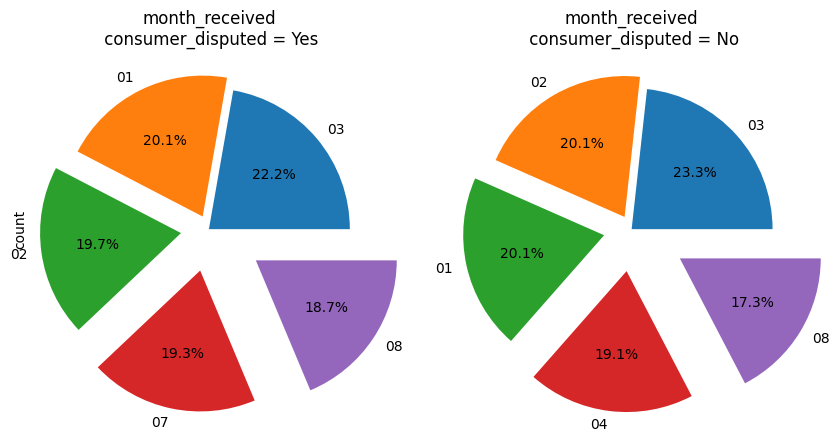

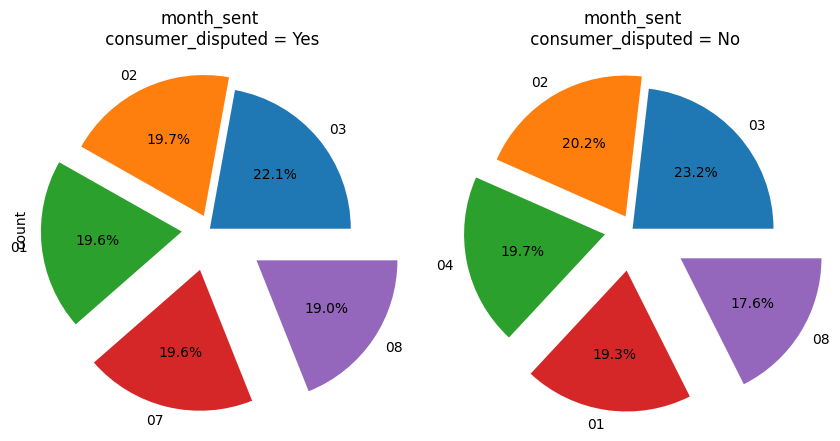

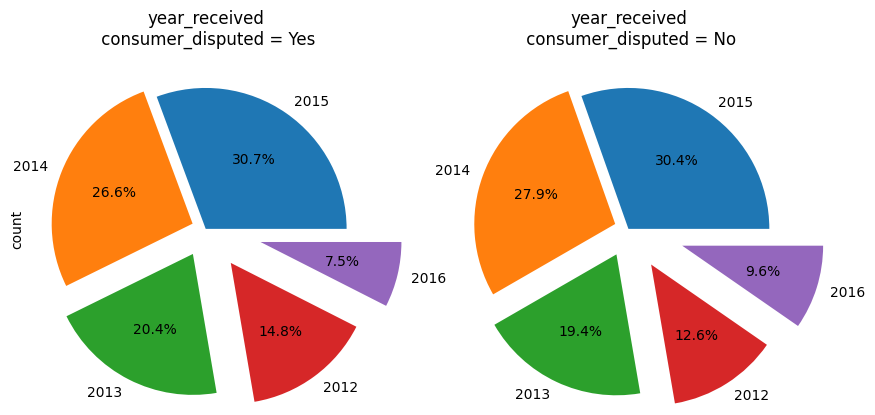

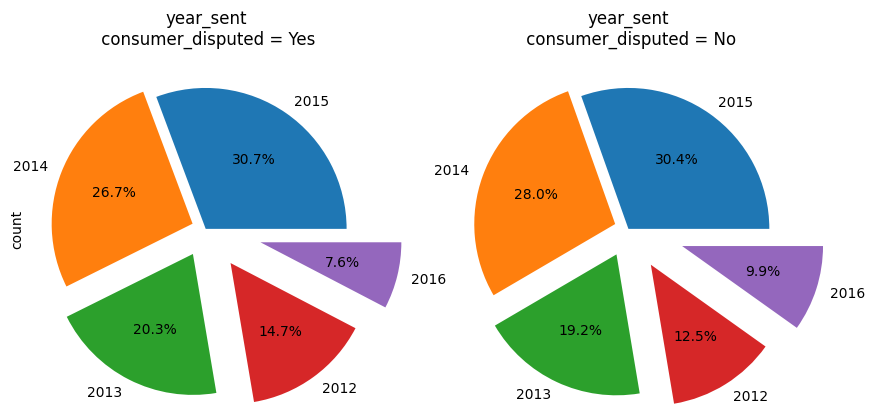

In [ ]:
for col in new_categorical_columns:
  pieplot(disputed_yes_df, disputed_no_df, col, 'consumer_disputed = Yes', 'consumer_disputed = No')

In [ ]:
def boxplot(df, col, group_by, figsize=(8, 5), samp_size=10000):
    '''
    This function makes a box plot for a Spark dataframe df
    grouping them by a column name called group_by and their
    aggrigate on another column called col.
    '''

    # Selecting sample for the large dataset
    # For samll data sampling is not done. For the large data
    # sample size is the specified number.

    fraction = samp_size/df.shape[0]
    pd_df = df.sample(frac=fraction)
    # Making plot
    pd_df.boxplot(col, by=group_by, figsize=figsize)
    plt.ylabel(col)
    plt.title(None)
    plt.show()

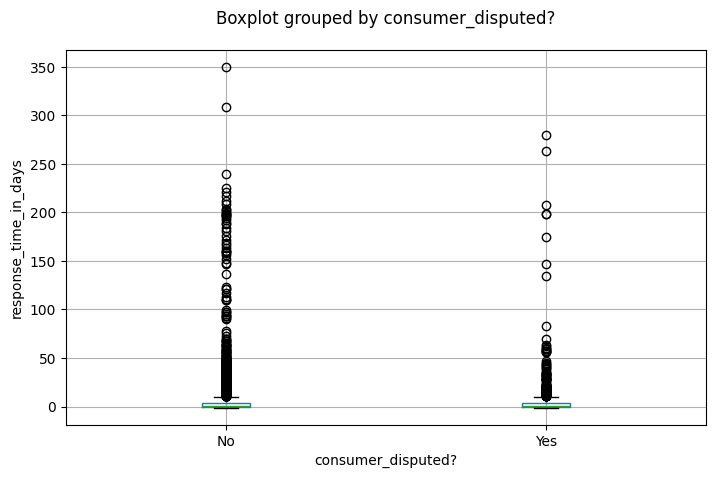

In [ ]:
boxplot(train, 'response_time_in_days', 'consumer_disputed?')

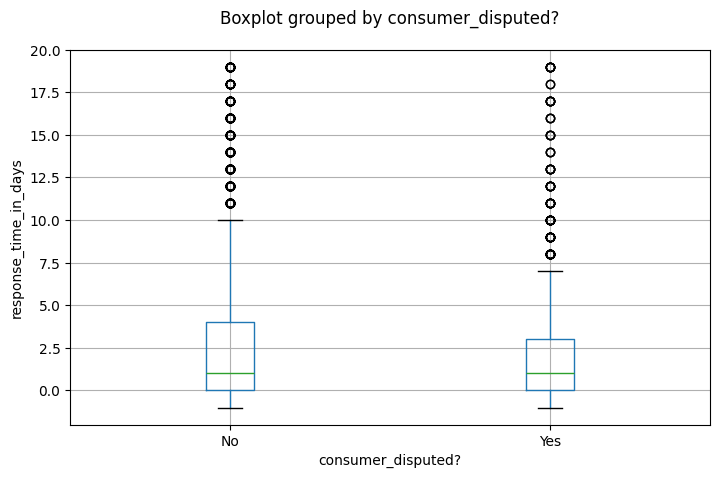

In [ ]:
df_response_time = train.loc[train['response_time_in_days'] < 20]
boxplot(df_response_time, 'response_time_in_days', 'consumer_disputed?')

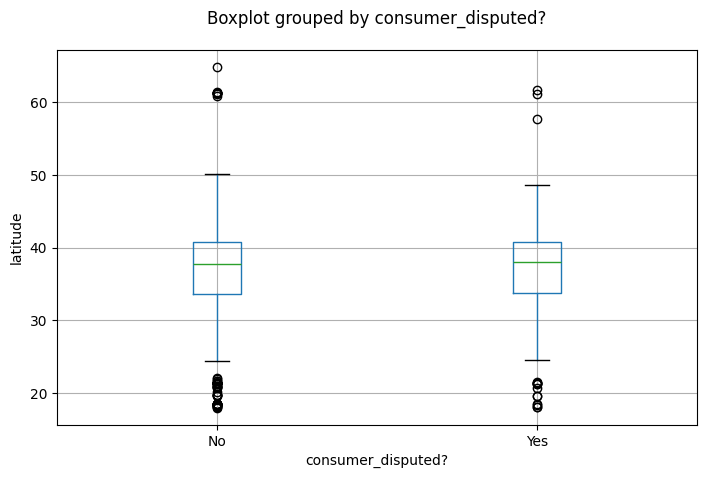

In [ ]:
boxplot(train, 'latitude', 'consumer_disputed?')

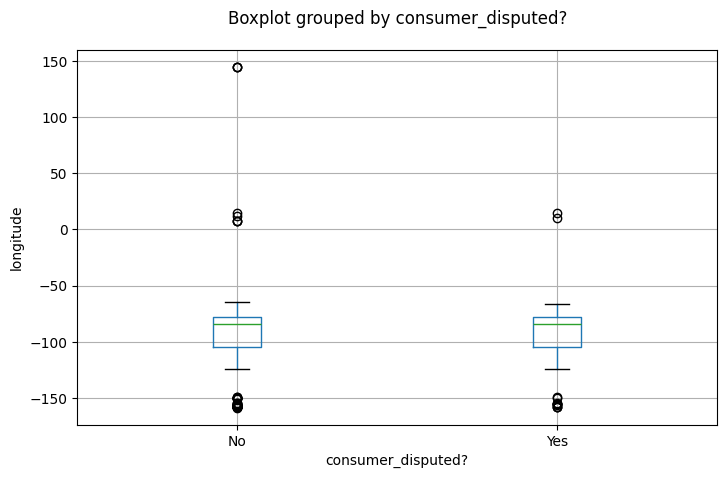

In [ ]:
boxplot(train, 'longitude', 'consumer_disputed?')

In [ ]:
# Extracting latitude values from lat_long_df
latitude = train['latitude'].values

# Extracting longitude values from lat_long_df
longitude = train['longitude'].values

# Creating a new column 'location' in dataframe
# and assigning a tuple of latitude and longitude for each row
train['location'] = [(latitude[i], longitude[i]) for i in range(len(latitude))]
train.head()

,product,sub_product,issue,sub_issue,consumer_complaint_narrative,company_public_response,company,state,tags,consumer_consent_provided,...,timely_response,consumer_disputed?,response_time_in_days,month_received,month_sent,year_received,year_sent,latitude,longitude,location
0,Mortgage,Other mortgage,"Loan modification,collection,foreclosure","Loan modification,collection,foreclosure",Consumer complaint narrative unknown,Company response unknown,U.S. Bancorp,CA,Tag unknown,Consent unknown,...,Yes,Yes,4,08,09,2013,2013,39.1237,-121.6611,"(39.1237, -121.6611)"
1,Mortgage,Other mortgage,"Loan servicing, payments, escrow account","Loan servicing, payments, escrow account",Consumer complaint narrative unknown,Company response unknown,Wells Fargo & Company,CA,Tag unknown,Consent unknown,...,Yes,Yes,4,08,09,2013,2013,34.1678,-118.1261,"(34.1678, -118.1261)"
2,Credit reporting,Credit reporting - credit reporting,Incorrect information on credit report,Account status,Consumer complaint narrative unknown,Company response unknown,Wells Fargo & Company,NY,Tag unknown,Consent unknown,...,Yes,No,19,08,09,2013,2013,40.9436,-72.9913,"(40.9436, -72.9913)"
3,Student loan,Non-federal student loan,Repaying your loan,Repaying your loan,Consumer complaint narrative unknown,Company response unknown,"Navient Solutions, Inc.",MD,Tag unknown,Consent unknown,...,Yes,Yes,0,08,08,2013,2013,38.9871,-76.4715,"(38.9871, -76.4715)"
4,Debt collection,Credit card,False statements or representation,Attempted to collect wrong amount,Consumer complaint narrative unknown,Company response unknown,Resurgent Capital Services L.P.,GA,Tag unknown,Consent unknown,...,Yes,Yes,0,08,08,2013,2013,33.8369,-84.6307,"(33.8369, -84.6307)"


In [ ]:
# Create an empty DataFrame to store location data
location_df = pd.DataFrame()
# Create an empty list to store latitude values
latitudes = []
# Create an empty list to store longitude values
longitudes = []
# Create an empty list to store count values
counts = []

# Iterate over the unique locations in the DataFrame
for key, value in Counter(consumer_complaint_df['location']).items():
    # Append the latitude value to the latitudes list
    latitudes.append(key[0])
    # Append the longitude value to the longitudes list
    longitudes.append(key[1])
    # Append the count value to the counts list
    counts.append(value)

# Add the latitude, longitude, and count lists as columns to the location_df DataFrame
location_df['latitude'] = latitudes
location_df['longitude'] = longitudes
location_df['count'] = counts
location_df.head()

,latitude,longitude,count
0,39.1237,-121.6611,38
1,34.1678,-118.1261,144
2,40.9436,-72.9913,27
3,38.9871,-76.4715,5
4,33.8369,-84.6307,70


In [ ]:
fig = px.density_mapbox(location_df, lat = 'latitude', lon = 'longitude', z = 'count',
                        radius = 18,
                        center = dict(lat = 38.6,
                                      lon = -100.3),
                        zoom = 3,
                        mapbox_style = 'open-street-map')
fig.show()

### Sentiment Analysis

The dataset contains a feature called `consumer_complaint_narrative` which contains text in unstructured form. Instead of dropping this column, we use a pre-trained sentiment analysis network from HuggingFace to calculate the negative and neutral sentiment in the text (on a scale between 0 to 1) and use it as a proxy for complaint description.

In [ ]:
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer
from scipy.special import softmax

In [ ]:
task='sentiment'
MODEL = f"cardiffnlp/twitter-roberta-base-{task}"

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)
model.save_pretrained(MODEL)

In [ ]:
consumer_complaint_narratives = train[['consumer_complaint_narrative']]
consumer_complaint_narrative_known = consumer_complaint_narratives.loc[consumer_complaint_narratives['consumer_complaint_narrative'] != 'Consumer complaint narrative unknown']
consumer_complaint_narrative_known.head()

,consumer_complaint_narrative
251824,On my report there is another XXXX XXXX living...
305134,"While checking my personal credit report, I di..."
507727,Attempts to resolve this directly with the ban...
208983,MY MORTGAGE LOAN HAS HAD XXXX DIFFERENT SERVIC...
268134,"I was "" invited '' to apply for a personal loa..."


In [ ]:
consumer_complaint_narratives.shape

(500361, 1)

In [ ]:
def get_scores(text):
  '''
  returns the negative, neutral and positive sentiment scores for a given text.
  '''
  encoded_input = tokenizer(text, return_tensors='pt')
  reduced_encoded_input = {}
  size_lim = min(100, encoded_input['input_ids'].shape[1])
  reduced_encoded_input['input_ids'] = encoded_input['input_ids'][0][:size_lim].reshape(1,size_lim)
  reduced_encoded_input['attention_mask'] = encoded_input['attention_mask'][0][:size_lim].reshape(1,size_lim)
  output = model(**reduced_encoded_input)
  scores = output[0][0].detach().numpy()
  scores = softmax(scores)

  return scores

In [ ]:
scores_list = []

In [ ]:
batch_0 = consumer_complaint_narrative_known[:10000]
batch_1 = consumer_complaint_narrative_known[10000:20000]
batch_2 = consumer_complaint_narrative_known[20000:30000]
batch_3 = consumer_complaint_narrative_known[30000:40000]
batch_4 = consumer_complaint_narrative_known[40000:50000]
batch_5 = consumer_complaint_narrative_known[50000:60000]
batch_6 = consumer_complaint_narrative_known[60000:]

In [ ]:
batch = batch_6

In [ ]:
for ind, text in enumerate(batch.values):
    scores = get_scores(text[0])
    scores_list.append(scores)
    if ind % 1000 == 0:
      print(ind)

0


In [ ]:
# with open(f'{get_cwd}/train_scores.pkl', 'wb') as f:
#   pickle.dump(scores_list, f)

with open(f'{get_cwd}/train_scores.pkl', 'rb') as f:
  scores_list = pickle.load(f)

In [ ]:
narrative_unknown = 'Consumer complaint narrative unknown'
narrative_unknown_score = get_scores(narrative_unknown)
narrative_unknown_score

array([0.37804025, 0.60834557, 0.01361418], dtype=float32)

In [ ]:
def sentiment_scores(narrative_df, known_df):

  negative_scores = []
  neutral_scores = []
  positive_scores = []
  c = 0

  for index in narrative_df.index.values:
    if index in known_df.index.values:
      score = scores_list[c]
      negative_scores.append(score[0])
      neutral_scores.append(score[1])
      positive_scores.append(score[2])
      c += 1
    else:
      negative_scores.append(narrative_unknown_score[0])
      neutral_scores.append(narrative_unknown_score[1])
      positive_scores.append(narrative_unknown_score[2])

  return negative_scores, neutral_scores, positive_scores

In [ ]:
test_index = 305134

In [ ]:
train.at[test_index,'consumer_complaint_narrative']

'While checking my personal credit report, I discovered an Unauthorized and Fraudulent credit inquiry made without my KNOWLEDGE or CONSENT by XXXX on or about XX/XX/XXXX on EXPERIAN credit file. I did not authorized anyone employed by this company to make any inquiry and view my credit report. XXXX has violated the Fair Credit Reporting Act Section XXXX ( c ). They were not legally entitled to make this fraudulent inquiry. This is a serious breach of my privacy rights. I am requesting that they mail me a copy of my signed authorization form that gave them the right to view my credit within five ( 5 ) business days so that I can verify its validity and advised them that if they can not provide me with proof that I authorized them to view my credit report then I am demanding that they contact the credit bureaus and have them remove the unauthorized and fraudulent hard inquiry immediately. \n'

In [ ]:
print('Negative sentiment score:', get_scores(train.at[test_index,'consumer_complaint_narrative'])[0])
print('Neutral sentiment score:', get_scores(train.at[test_index,'consumer_complaint_narrative'])[1])
print('Positive sentiment score:', get_scores(train.at[test_index,'consumer_complaint_narrative'])[2])

Negative sentiment score: 0.94378483
Neutral sentiment score: 0.052336205
Positive sentiment score: 0.003878915


In [ ]:
negative_scores, neutral_scores, _ = sentiment_scores(consumer_complaint_narratives, consumer_complaint_narrative_known)

In [ ]:
assert len(negative_scores) == train.shape[0]

In [ ]:
train['negative_sentiment'] = negative_scores
train['neutral_sentiment'] = neutral_scores

In [ ]:
train.head()

,product,sub_product,issue,sub_issue,consumer_complaint_narrative,company_public_response,company,state,tags,consumer_consent_provided,...,consumer_disputed?,response_time_in_days,month_received,month_sent,year_received,year_sent,latitude,longitude,negative_sentiment,neutral_sentiment
251824,Credit reporting,Credit reporting - credit reporting,Incorrect information on credit report,Information is not mine,On my report there is another XXXX XXXX living...,Company chooses not to provide a public response,Experian,OH,Tag unknown,Consent provided,...,No,0,07,07,2015,2015,40.8116,-81.4973,0.829042,0.157999
305134,Credit reporting,Credit reporting - credit reporting,Improper use of my credit report,Report improperly shared by CRC,"While checking my personal credit report, I di...",Company chooses not to provide a public response,Experian,WA,Tag unknown,Consent provided,...,No,0,10,10,2015,2015,47.1424,-122.2652,0.943785,0.052336
33818,Debt collection,"Other (i.e. phone, health club, etc.)",Cont'd attempts collect debt not owed,Debt is not mine,Consumer complaint narrative unknown,Company response unknown,Resurgent Capital Services L.P.,VA,Tag unknown,Consent unknown,...,No,3,02,02,2014,2014,36.8348,-76.0961,0.378040,0.608346
176436,Debt collection,Medical,Improper contact or sharing of info,Contacted me after I asked not to,Consumer complaint narrative unknown,Company response unknown,"Retrieval-Masters Creditors Bureau, Inc.",NY,Tag unknown,Consent unknown,...,No,0,12,12,2014,2014,40.7651,-73.9638,0.378040,0.608346
204034,Mortgage,Other mortgage,Other,Other,Consumer complaint narrative unknown,Company response unknown,PNC Bank N.A.,TX,Tag unknown,Consent unknown,...,No,6,03,03,2015,2015,33.1377,-96.7524,0.378040,0.608346


In [ ]:
train.loc[[test_index]]

,product,sub_product,issue,sub_issue,consumer_complaint_narrative,company_public_response,company,state,tags,consumer_consent_provided,...,consumer_disputed?,response_time_in_days,month_received,month_sent,year_received,year_sent,latitude,longitude,negative_sentiment,neutral_sentiment
305134,Credit reporting,Credit reporting - credit reporting,Improper use of my credit report,Report improperly shared by CRC,"While checking my personal credit report, I di...",Company chooses not to provide a public response,Experian,WA,Tag unknown,Consent provided,...,No,0,10,10,2015,2015,47.1424,-122.2652,0.943785,0.052336


In [ ]:
train.drop(columns='consumer_complaint_narrative', inplace = True)
train.head()

,product,sub_product,issue,sub_issue,company_public_response,company,state,tags,consumer_consent_provided,submitted_via,...,consumer_disputed?,response_time_in_days,month_received,month_sent,year_received,year_sent,latitude,longitude,negative_sentiment,neutral_sentiment
251824,Credit reporting,Credit reporting - credit reporting,Incorrect information on credit report,Information is not mine,Company chooses not to provide a public response,Experian,OH,Tag unknown,Consent provided,Web,...,No,0,07,07,2015,2015,40.8116,-81.4973,0.829042,0.157999
305134,Credit reporting,Credit reporting - credit reporting,Improper use of my credit report,Report improperly shared by CRC,Company chooses not to provide a public response,Experian,WA,Tag unknown,Consent provided,Web,...,No,0,10,10,2015,2015,47.1424,-122.2652,0.943785,0.052336
33818,Debt collection,"Other (i.e. phone, health club, etc.)",Cont'd attempts collect debt not owed,Debt is not mine,Company response unknown,Resurgent Capital Services L.P.,VA,Tag unknown,Consent unknown,Fax,...,No,3,02,02,2014,2014,36.8348,-76.0961,0.378040,0.608346
176436,Debt collection,Medical,Improper contact or sharing of info,Contacted me after I asked not to,Company response unknown,"Retrieval-Masters Creditors Bureau, Inc.",NY,Tag unknown,Consent unknown,Web,...,No,0,12,12,2014,2014,40.7651,-73.9638,0.378040,0.608346
204034,Mortgage,Other mortgage,Other,Other,Company response unknown,PNC Bank N.A.,TX,Tag unknown,Consent unknown,Referral,...,No,6,03,03,2015,2015,33.1377,-96.7524,0.378040,0.608346


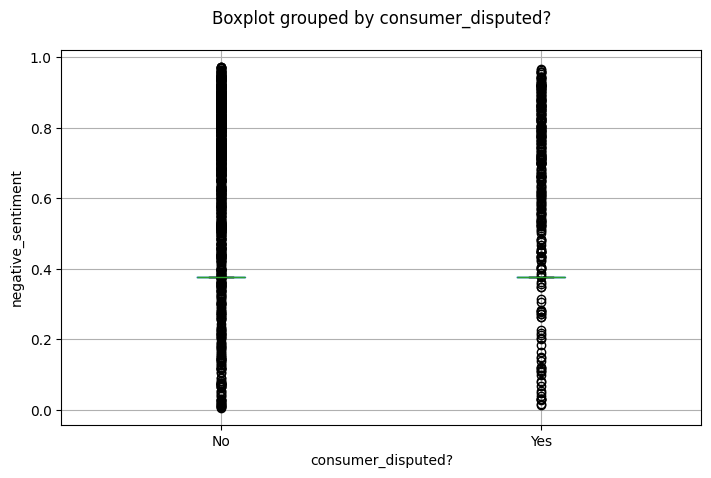

In [ ]:
boxplot(train, 'negative_sentiment', 'consumer_disputed?')

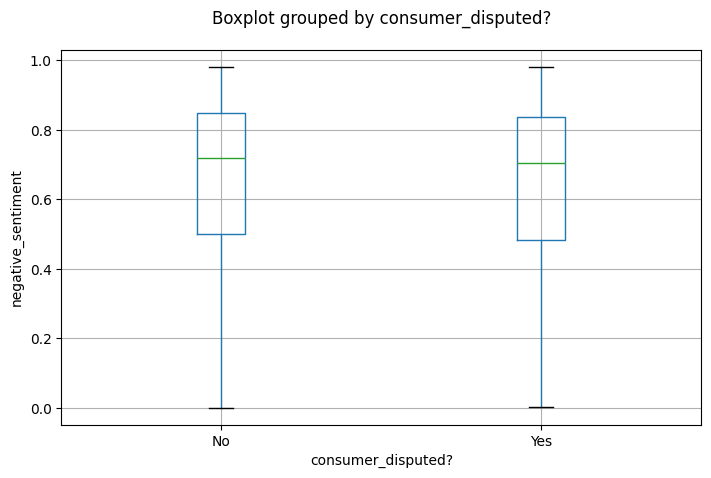

In [ ]:
df_above = train.loc[train['negative_sentiment'] >=  0.378041]
df_below = train.loc[train['negative_sentiment'] <=  0.378039]
df_negative_scores =  pd.concat([df_above, df_below])
boxplot(df_negative_scores, 'negative_sentiment', 'consumer_disputed?')

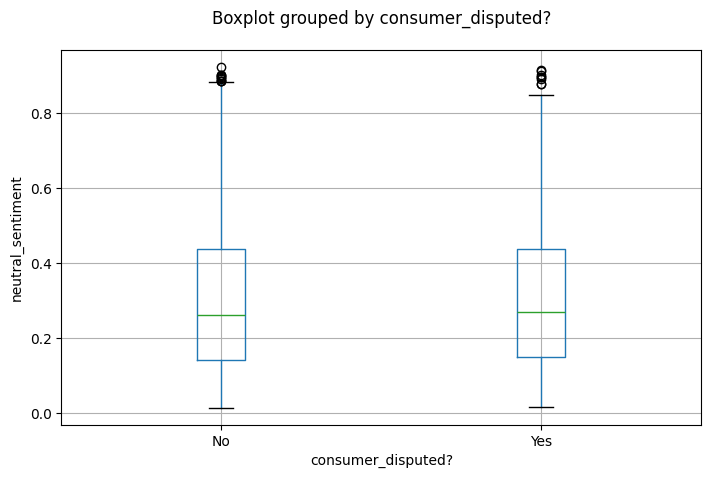

In [ ]:
df_above = train.loc[train['neutral_sentiment'] >=  0.60834560]
df_below = train.loc[train['neutral_sentiment'] <=  0.60834550]
df_neutral_scores =  pd.concat([df_above, df_below])
boxplot(df_neutral_scores, 'neutral_sentiment', 'consumer_disputed?')

In [ ]:
train.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 500361 entries, 251824 to 128037
Data columns (total 22 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   product                       500361 non-null  object 
 1   sub_product                   500361 non-null  object 
 2   issue                         500361 non-null  object 
 3   sub_issue                     500361 non-null  object 
 4   company_public_response       500361 non-null  object 
 5   company                       500361 non-null  object 
 6   state                         500361 non-null  object 
 7   tags                          500361 non-null  object 
 8   consumer_consent_provided     500361 non-null  object 
 9   submitted_via                 500361 non-null  object 
 10  company_response_to_consumer  500361 non-null  object 
 11  timely_response               500361 non-null  object 
 12  consumer_disputed?            500361 non-nul

In [ ]:
consumer_complaint_narratives = test[['consumer_complaint_narrative']]
consumer_complaint_narrative_known = consumer_complaint_narratives.loc[consumer_complaint_narratives['consumer_complaint_narrative'] != 'Consumer complaint narrative unknown']
consumer_complaint_narrative_known.head()

,consumer_complaint_narrative
306466,NationStar is playing the victim instead of ac...
254673,The terms of the loan modification that Ocwen ...
268651,URGENT - Hi. I just received a call from Wells...
230590,I am with Bank of America now I was charged XX...
315424,I have full or Part time status in XXXX school...


In [ ]:
consumer_complaint_narrative_known.shape

(6583, 1)

In [ ]:
scores_list = []

In [ ]:
batch_0 = consumer_complaint_narrative_known[:10000]

In [ ]:
batch = batch_0

In [ ]:
for ind, text in enumerate(batch.values):
    scores = get_scores(text[0])
    scores_list.append(scores)
    if ind % 1000 == 0:
      print(ind)

0
1000
2000
3000
4000
5000
6000


In [ ]:
# with open(f'{get_cwd}/test_scores.pkl', 'wb') as f:
#   pickle.dump(scores_list, f)

with open(f'{get_cwd}/test_scores.pkl', 'rb') as f:
  scores_list = pickle.load(f)

In [ ]:
test_index = 306466

In [ ]:
test.at[test_index,'consumer_complaint_narrative']

"NationStar is playing the victim instead of actually reviewed my account. They were then and even now. I received a letter from them in the mail on XXXX XXXX, 2015. The letter is dated XXXX XXXX, 2015. My question is, how long did it sit on someone 's desk before actually being placed in the mail to be sent to me. In my opinion, seems as though they know these type of issues are time sensitive, so they hold it as long as they can, so by the time it makes it to the customers it 's already to late. With that being said they said in the letter, that their goal is to provide a response no later than XXXX XXXX, 2015. In my opinion, they only sent this letter because they were contacted by you all at Consumer Financial Protection and Nationstar is just trying to make themselves look good. They know that they are a bunch of crooks, preying on the low-income family member. Not fair, not fair at all. I hope that someone could really review my case and take care of this. I was cheated and they 

In [ ]:
print('Negative sentiment score:', get_scores(test.at[test_index,'consumer_complaint_narrative'])[0])
print('Neutral sentiment score:', get_scores(test.at[test_index,'consumer_complaint_narrative'])[1])
print('Positive sentiment score:', get_scores(test.at[test_index,'consumer_complaint_narrative'])[2])

Negative sentiment score: 0.729745
Neutral sentiment score: 0.25194424
Positive sentiment score: 0.018310841


In [ ]:
negative_scores, neutral_scores, _ = sentiment_scores(consumer_complaint_narratives, consumer_complaint_narrative_known)

In [ ]:
assert len(negative_scores) == test.shape[0]

In [ ]:
test['negative_sentiment'] = negative_scores
test['neutral_sentiment'] = neutral_scores

In [ ]:
test.head()

,product,sub_product,issue,sub_issue,consumer_complaint_narrative,company_public_response,company,state,tags,consumer_consent_provided,...,consumer_disputed?,response_time_in_days,month_received,month_sent,year_received,year_sent,latitude,longitude,negative_sentiment,neutral_sentiment
334801,Mortgage,Other mortgage,"Loan servicing, payments, escrow account","Loan servicing, payments, escrow account",Consumer complaint narrative unknown,Company response unknown,Bank of America,WI,Tag unknown,Consent unknown,...,No,7,07,07,2012,2012,42.5620,-89.0860,0.378040,0.608346
306466,Mortgage,Conventional fixed mortgage,"Loan modification,collection,foreclosure","Loan modification,collection,foreclosure",NationStar is playing the victim instead of ac...,Company response unknown,Nationstar Mortgage,TN,Tag unknown,Consent provided,...,No,0,10,10,2015,2015,35.0312,-89.8124,0.729745,0.251944
351257,Bank account or service,Savings account,"Account opening, closing, or management","Account opening, closing, or management",Consumer complaint narrative unknown,Company response unknown,JPMorgan Chase & Co.,NY,Older American,Consent unknown,...,No,1,12,12,2012,2012,40.9079,-73.8380,0.378040,0.608346
254673,Mortgage,Conventional adjustable mortgage (ARM),"Loan modification,collection,foreclosure","Loan modification,collection,foreclosure",The terms of the loan modification that Ocwen ...,Company response unknown,Ocwen,FL,Tag unknown,Consent provided,...,No,0,06,06,2015,2015,28.0168,-80.6739,0.852517,0.135132
494319,Debt collection,I do not know,Cont'd attempts collect debt not owed,Debt is not mine,Consumer complaint narrative unknown,Company believes it acted appropriately as aut...,"American Credit Acceptance, LLC",GA,Tag unknown,Consent unknown,...,No,29,12,01,2015,2016,33.7683,-84.3935,0.378040,0.608346


In [ ]:
test.loc[[test_index]]

,product,sub_product,issue,sub_issue,consumer_complaint_narrative,company_public_response,company,state,tags,consumer_consent_provided,...,consumer_disputed?,response_time_in_days,month_received,month_sent,year_received,year_sent,latitude,longitude,negative_sentiment,neutral_sentiment
306466,Mortgage,Conventional fixed mortgage,"Loan modification,collection,foreclosure","Loan modification,collection,foreclosure",NationStar is playing the victim instead of ac...,Company response unknown,Nationstar Mortgage,TN,Tag unknown,Consent provided,...,No,0,10,10,2015,2015,35.0312,-89.8124,0.729745,0.251944


In [ ]:
test.drop(columns='consumer_complaint_narrative', inplace = True)
test.head()

,product,sub_product,issue,sub_issue,company_public_response,company,state,tags,consumer_consent_provided,submitted_via,...,consumer_disputed?,response_time_in_days,month_received,month_sent,year_received,year_sent,latitude,longitude,negative_sentiment,neutral_sentiment
334801,Mortgage,Other mortgage,"Loan servicing, payments, escrow account","Loan servicing, payments, escrow account",Company response unknown,Bank of America,WI,Tag unknown,Consent unknown,Web,...,No,7,07,07,2012,2012,42.5620,-89.0860,0.378040,0.608346
306466,Mortgage,Conventional fixed mortgage,"Loan modification,collection,foreclosure","Loan modification,collection,foreclosure",Company response unknown,Nationstar Mortgage,TN,Tag unknown,Consent provided,Web,...,No,0,10,10,2015,2015,35.0312,-89.8124,0.729745,0.251944
351257,Bank account or service,Savings account,"Account opening, closing, or management","Account opening, closing, or management",Company response unknown,JPMorgan Chase & Co.,NY,Older American,Consent unknown,Phone,...,No,1,12,12,2012,2012,40.9079,-73.8380,0.378040,0.608346
254673,Mortgage,Conventional adjustable mortgage (ARM),"Loan modification,collection,foreclosure","Loan modification,collection,foreclosure",Company response unknown,Ocwen,FL,Tag unknown,Consent provided,Web,...,No,0,06,06,2015,2015,28.0168,-80.6739,0.852517,0.135132
494319,Debt collection,I do not know,Cont'd attempts collect debt not owed,Debt is not mine,Company believes it acted appropriately as aut...,"American Credit Acceptance, LLC",GA,Tag unknown,Consent unknown,Referral,...,No,29,12,01,2015,2016,33.7683,-84.3935,0.378040,0.608346


**Key Step:** Converting months and years to categories (objects) instead of numerical because otherwise month 12 will get more weightage than month 1 for no reason.

In [ ]:
train['month_received'] = train['month_received'].astype('object')
train['year_received'] = train['year_received'].astype('object')
train['month_sent'] = train['month_sent'].astype('object')
train['year_sent'] = train['year_sent'].astype('object')

In [ ]:
train.head()

,product,sub_product,issue,sub_issue,company_public_response,company,state,tags,consumer_consent_provided,submitted_via,...,consumer_disputed?,response_time_in_days,month_received,month_sent,year_received,year_sent,latitude,longitude,negative_sentiment,neutral_sentiment
251824,Credit reporting,Credit reporting - credit reporting,Incorrect information on credit report,Information is not mine,Company chooses not to provide a public response,Experian,OH,Tag unknown,Consent provided,Web,...,No,0,07,07,2015,2015,40.8116,-81.4973,0.829042,0.157999
305134,Credit reporting,Credit reporting - credit reporting,Improper use of my credit report,Report improperly shared by CRC,Company chooses not to provide a public response,Experian,WA,Tag unknown,Consent provided,Web,...,No,0,10,10,2015,2015,47.1424,-122.2652,0.943785,0.052336
33818,Debt collection,"Other (i.e. phone, health club, etc.)",Cont'd attempts collect debt not owed,Debt is not mine,Company response unknown,Resurgent Capital Services L.P.,VA,Tag unknown,Consent unknown,Fax,...,No,3,02,02,2014,2014,36.8348,-76.0961,0.378040,0.608346
176436,Debt collection,Medical,Improper contact or sharing of info,Contacted me after I asked not to,Company response unknown,"Retrieval-Masters Creditors Bureau, Inc.",NY,Tag unknown,Consent unknown,Web,...,No,0,12,12,2014,2014,40.7651,-73.9638,0.378040,0.608346
204034,Mortgage,Other mortgage,Other,Other,Company response unknown,PNC Bank N.A.,TX,Tag unknown,Consent unknown,Referral,...,No,6,03,03,2015,2015,33.1377,-96.7524,0.378040,0.608346


In [ ]:
if 'location' in train.columns:
  train.drop(columns=['location'], inplace=True)

In [ ]:
# Let's count the total number of categories in each feature
total_categories = 0
# looping over categorical features
string_columns = train.select_dtypes(include=['object']).columns
for col in string_columns:
    num_categories = len(Counter(train[col].values))
    print('Number of categories in column:', col, '=', num_categories)
    # counting total categories in the dataset
    total_categories += num_categories
print('\nTotal number of categories =', total_categories)

Number of categories in column: product = 11
Number of categories in column: sub_product = 48
Number of categories in column: issue = 95
Number of categories in column: sub_issue = 139
Number of categories in column: company_public_response = 11
Number of categories in column: company = 3529
Number of categories in column: state = 64
Number of categories in column: tags = 4
Number of categories in column: consumer_consent_provided = 5
Number of categories in column: submitted_via = 6
Number of categories in column: company_response_to_consumer = 8
Number of categories in column: timely_response = 2
Number of categories in column: consumer_disputed? = 2
Number of categories in column: month_received = 12
Number of categories in column: month_sent = 12
Number of categories in column: year_received = 6
Number of categories in column: year_sent = 6

Total number of categories = 3960


In [ ]:
test['month_received'] = test['month_received'].astype('object')
test['year_received'] = test['year_received'].astype('object')
test['month_sent'] = test['month_sent'].astype('object')
test['year_sent'] = test['year_sent'].astype('object')

In [ ]:
train.to_csv(f'{get_cwd}/train.csv')
test.to_csv(f'{get_cwd}/test.csv')

# UNIVARIATE ANALYSIS

Key takeaways: We find that from chi-square analysis, `company_response_to_consumer` was the most important featrue distinguishing between the two classes. We also looked at and compared the observed and expected distribution of company response. We draw the following conclusions about company response to consumer by comparing the observed and expected distribution:
  * _Closed with explanation:_ Even though disputed responses were closed with explanation more than the expectation, perhaps the explanation provided did not satisfy the consumers. A better explanation can be provided by companies.
  * _Closed with monetary relief:_ We notice that the disputed cases were closed with monetary relief in lower numbers than the expectation. This suggests that companies can provide some monetary compensation to satisfy the consumer.
  * _Closed with non-monetary relief:_ Even though disputed responses were closed with non-monetary relief lower than the expectation, perhaps consumers were compensated in other ways such as rescinding unauthorized credit card tarnsactions, correcting information on the credit report, etc. This suggests that consumers aren't always looking for monetary compensation.
  * _Closed without relief:_ We notice that the disputed cases were closed without any relief in larger numbers than the expectation. This suggests that companies can provide some sort of relief (monetary or otherwise) to satisfy the consumer.

## Numerical columns

In [ ]:
def ttest(df, numerical_columns, target):
  # Iterate over each numerical feature
  for feature in numerical_columns:
      # Select values of the current feature where 'target' is 0
      feature_0 = df.loc[df[target] == 0][feature].values
      # Select values of the current feature where 'target' is 1
      feature_1 = df.loc[df[target] == 1][feature].values
      # Perform a t-test on the two sets of values
      ttest_result = ttest_ind(feature_0, feature_1, equal_var=False)
      if ttest_result.pvalue < 0.05:
          print(feature)
          print('t-statistic =', round(ttest_result.statistic, 2), ', p-value =', round(ttest_result.pvalue, 5))
          print('********')

In [ ]:
numerical_columns = train.select_dtypes(include=np.number).columns.values

In [ ]:
train['consumer_disputed?'] = train['consumer_disputed?'].map({'Yes':1 ,'No':0})

In [ ]:
ttest(train, numerical_columns, 'consumer_disputed?')

response_time_in_days
t-statistic = 19.47 , p-value = 0.0
********
latitude
t-statistic = -5.95 , p-value = 0.0
********
longitude
t-statistic = 8.18 , p-value = 0.0
********
negative_sentiment
t-statistic = -12.1 , p-value = 0.0
********
neutral_sentiment
t-statistic = 14.25 , p-value = 0.0
********


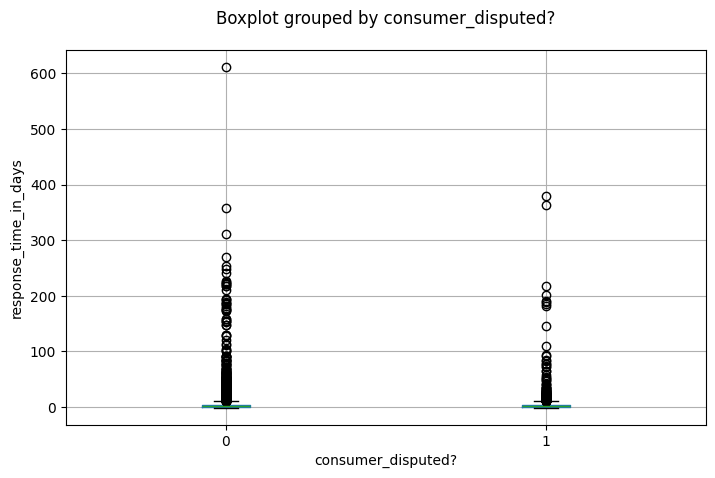

In [ ]:
boxplot(train, 'response_time_in_days', 'consumer_disputed?')

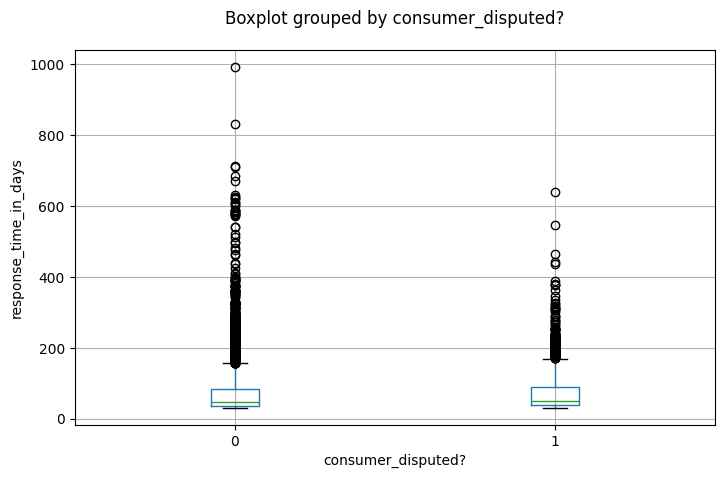

In [ ]:
boxplot(train.loc[train['response_time_in_days'] > 30], 'response_time_in_days', 'consumer_disputed?')

## Categorical columns

In [ ]:
categorical_columns = train.select_dtypes(include='object').columns.values
categorical_columns

array(['product', 'sub_product', 'issue', 'sub_issue',
       'company_public_response', 'company', 'state', 'tags',
       'consumer_consent_provided', 'submitted_via',
       'company_response_to_consumer', 'timely_response',
       'month_received', 'month_sent', 'year_received', 'year_sent'],
      dtype=object)

In [ ]:
def contingency_table(df, feature, target):
    '''
    The function takes a DataFrame df and a feature name
    as input and returns a contingency table. A contingency table is a
    table that shows the frequency distribution of two categorical variables.
    '''
    # Get the unique categories of the feature
    count_dict = Counter(df[feature])
    if len(count_dict) >= 4:
      dim = 4
      sorted_dict = sorted(count_dict.items(), key=lambda x: x[1], reverse=True)[:dim]
      feature_categories = [ent for ent, count in sorted_dict]
    else:
      dim = len(count_dict)
      feature_categories = list(count_dict.keys())

    # Create a contingency table with 2 rows and dim columns
    table = np.zeros((2, dim))
    # Iterate over the rows and columns of the table
    for row_ind, row in enumerate([0, 1]):
        for column in range(dim):
            # Count the number of occurrences where diabetesMed is equal to row and feature is equal to the category
            table[row_ind, column] = df.loc[(df[target] == row) & (df[feature] == feature_categories[column])].shape[0]

    return table

In [ ]:
print('feature name,', 'chi square value,', 'p value,', 'degree of freedom\n')
# iterate over categorical features
for feature in categorical_columns:
    # make contingency table
    table = contingency_table(train, feature, 'consumer_disputed?')
    # calculate chi-square value for the contingency table
    stat, p, dof, expected = chi2_contingency(table)
    print(f'{feature}, {round(stat)}, {round(p, 5)}, {dof}')

feature name, chi square value, p value, degree of freedom

product, 1999, 0.0, 3
sub_product, 1584, 0.0, 3
issue, 2063, 0.0, 3
sub_issue, 1196, 0.0, 3
company_public_response, 303, 0.0, 3
company, 50, 0.0, 3
state, 172, 0.0, 3
tags, 56, 0.0, 3
consumer_consent_provided, 423, 0.0, 3
submitted_via, 2141, 0.0, 3
company_response_to_consumer, 5427, 0.0, 3
timely_response, 510, 0.0, 1
month_received, 9, 0.02362, 3
month_sent, 19, 0.00033, 3
year_received, 336, 0.0, 3
year_sent, 352, 0.0, 3


In [ ]:
feature = 'company_response_to_consumer'
table = contingency_table(train, feature, 'consumer_disputed?')
stat, p, dof, expected = chi2_contingency(table)
print(feature)
print('observed distribution:\n', table)
print('expected distribution:\n', np.around(expected))

company_response_to_consumer
observed distribution:
 [[282422.  55132.  30720.  11718.]
 [ 81342.   8118.   3772.   4349.]]
expected distribution:
 [[289437.  50326.  27444.  12784.]
 [ 74327.  12924.   7048.   3283.]]


In [ ]:
table_1_4_4 = np.zeros((4, 2))
table_1_4_4[0, 0] = table[0,0]
table_1_4_4[1, 0] = table[0,1]
table_1_4_4[2, 0] = table[0,2]
table_1_4_4[3, 0] = table[0,3]
table_1_4_4[0, 1] = table[1,0]
table_1_4_4[1, 1] = table[1,1]
table_1_4_4[2, 1] = table[1,2]
table_1_4_4[3, 1] = table[1,3]
table_1_4_4

array([[282422.,  81342.],
       [ 55132.,   8118.],
       [ 30720.,   3772.],
       [ 11718.,   4349.]])

In [ ]:
table_2_4_4 = np.zeros((4, 2))
table_2_4_4[0, 0] = expected[0,0]
table_2_4_4[1, 0] = expected[0,1]
table_2_4_4[2, 0] = expected[0,2]
table_2_4_4[3, 0] = expected[0,3]
table_2_4_4[0, 1] = expected[1,0]
table_2_4_4[1, 1] = expected[1,1]
table_2_4_4[2, 1] = expected[1,2]
table_2_4_4[3, 1] = expected[1,3]
table_2_4_4

array([[289437.23763278,  74326.76236722],
       [ 50326.32498068,  12923.67501932],
       [ 27444.35733176,   7047.64266824],
       [ 12784.08005478,   3282.91994522]])

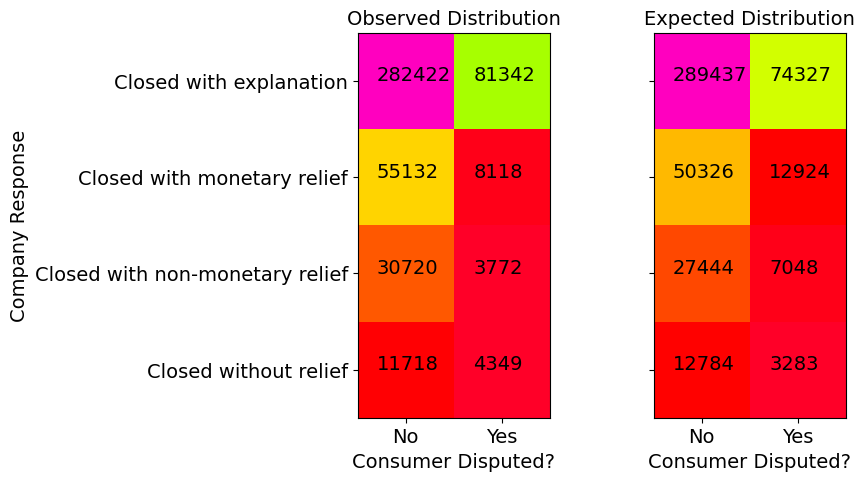

In [ ]:
figure(figsize=(7, 5))

plt.subplot(1,2,1)
plt.imshow(table_1_4_4, cmap=plt.cm.gist_rainbow)
plt.yticks(ticks=[0, 1, 2, 3], labels=['Closed with explanation', 'Closed with monetary relief',\
                                       'Closed with non-monetary relief', 'Closed without relief'], fontsize=14)
plt.xticks(ticks=[0, 1], labels=['No', 'Yes'], fontsize=14)
plt.xlabel('Consumer Disputed?', fontsize=14)
plt.ylabel('Company Response', fontsize=14)
plt.text(-0.3,0,round(table_1_4_4[0,0]), fontsize=14)
plt.text(-0.3,1,round(table_1_4_4[1,0]), fontsize=14)
plt.text(-0.3,2,round(table_1_4_4[2,0]), fontsize=14)
plt.text(-0.3,3,round(table_1_4_4[3,0]), fontsize=14)
plt.text(0.7,0,round(table_1_4_4[0,1]), fontsize=14)
plt.text(0.7,1,round(table_1_4_4[1,1]), fontsize=14)
plt.text(0.7,2,round(table_1_4_4[2,1]), fontsize=14)
plt.text(0.7,3,round(table_1_4_4[3,1]), fontsize=14)
plt.title('Observed Distribution', fontsize=14)

plt.subplot(1,2,2)
plt.imshow(table_2_4_4, cmap=plt.cm.gist_rainbow)
plt.yticks(ticks=[0, 1, 2, 3], labels=[], fontsize=14)
plt.xticks(ticks=[0, 1], labels=['No', 'Yes'], fontsize=14)
# plt.yticks(ticks=[0, 1, 2, 3], labels=['Closed with explanation', 'Closed with monetary relief',\
                                      #  'Closed with non-monetary relief', 'Closed without relief'], fontsize=14)
plt.xlabel('Consumer Disputed?', fontsize=14)
# plt.ylabel('Company Response', fontsize=14)
plt.text(-0.3,0,round(table_2_4_4[0,0]), fontsize=14)
plt.text(-0.3,1,round(table_2_4_4[1,0]), fontsize=14)
plt.text(-0.3,2,round(table_2_4_4[2,0]), fontsize=14)
plt.text(-0.3,3,round(table_2_4_4[3,0]), fontsize=14)
plt.text(0.7,0,round(table_2_4_4[0,1]), fontsize=14)
plt.text(0.7,1,round(table_2_4_4[1,1]), fontsize=14)
plt.text(0.7,2,round(table_2_4_4[2,1]), fontsize=14)
plt.text(0.7,3,round(table_2_4_4[3,1]), fontsize=14)
plt.title('Expected Distribution', fontsize=14);

# CORRELATION ANALYSIS

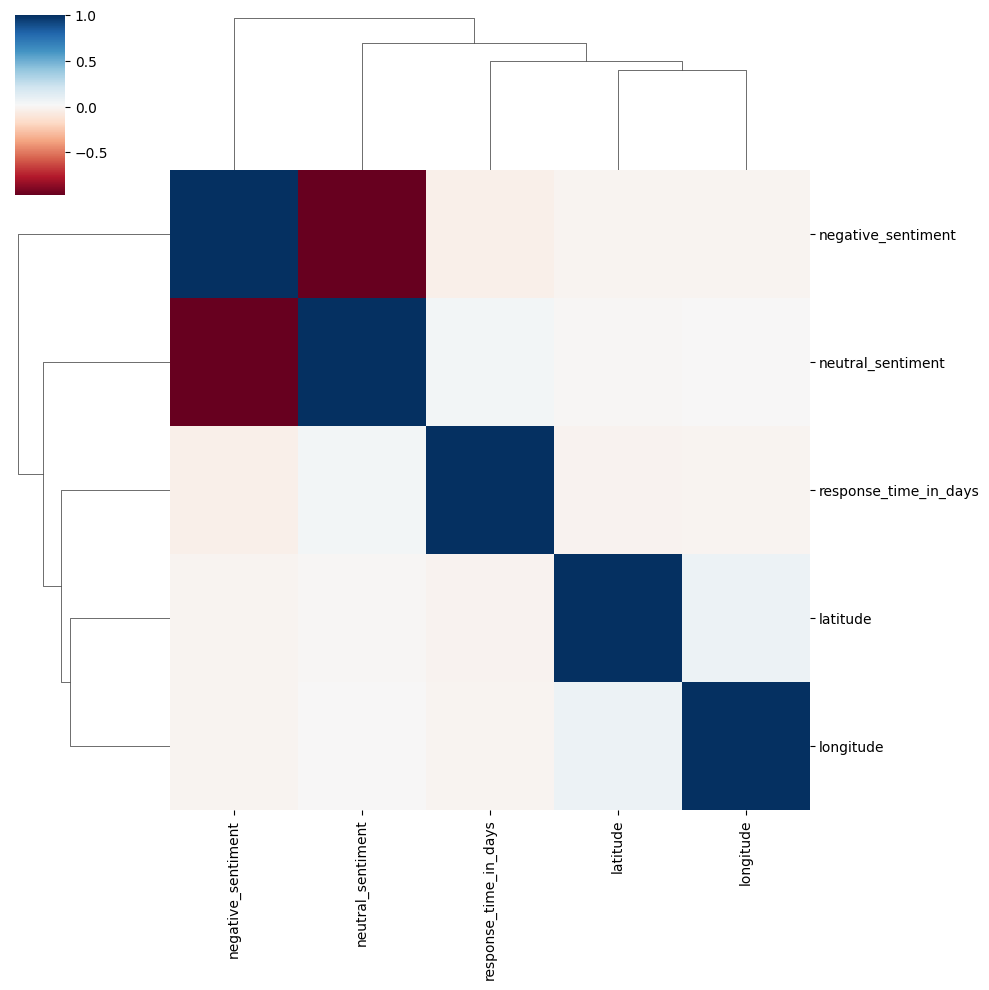

In [ ]:
sns.clustermap(train[numerical_columns].corr(), cmap='RdBu');

# MODEL DEVELOPMENT

## Data Processing

In this section, we continue processing the dataset before building the predictive model. Steps included in this section are:

* Encoding categorical columns: Most columns in the dataset are categorical and therefore we need to convert them into numerical form. We use one-hot encoding to do this conversion.

* Feature scaling: Numerical columns such as latitude, longitude, etc are scaled between 0-1 using the max absolute scaler.

In [ ]:
train = pd.read_csv(f'{get_cwd}/train.csv')
train.drop(columns=['Unnamed: 0'], inplace=True)
train.head()

,product,sub_product,issue,sub_issue,company_public_response,company,state,tags,consumer_consent_provided,submitted_via,company_response_to_consumer,timely_response,consumer_disputed?,response_time_in_days,month_received,month_sent,year_received,year_sent,latitude,longitude,negative_sentiment,neutral_sentiment
0,Credit reporting,Credit reporting - credit reporting,Incorrect information on credit report,Information is not mine,Company chooses not to provide a public response,Experian,OH,Tag unknown,Consent provided,Web,Closed with non-monetary relief,Yes,0,0,7,7,2015,2015,40.8116,-81.4973,0.829042,0.157999
1,Credit reporting,Credit reporting - credit reporting,Improper use of my credit report,Report improperly shared by CRC,Company chooses not to provide a public response,Experian,WA,Tag unknown,Consent provided,Web,Closed with explanation,Yes,0,0,10,10,2015,2015,47.1424,-122.2652,0.943785,0.052336
2,Debt collection,"Other (i.e. phone, health club, etc.)",Cont'd attempts collect debt not owed,Debt is not mine,Company response unknown,Resurgent Capital Services L.P.,VA,Tag unknown,Consent unknown,Fax,Closed with explanation,Yes,0,3,2,2,2014,2014,36.8348,-76.0961,0.378040,0.608346
3,Debt collection,Medical,Improper contact or sharing of info,Contacted me after I asked not to,Company response unknown,"Retrieval-Masters Creditors Bureau, Inc.",NY,Tag unknown,Consent unknown,Web,Closed,Yes,0,0,12,12,2014,2014,40.7651,-73.9638,0.378040,0.608346
4,Mortgage,Other mortgage,Other,Other,Company response unknown,PNC Bank N.A.,TX,Tag unknown,Consent unknown,Referral,Closed,Yes,0,6,3,3,2015,2015,33.1377,-96.7524,0.378040,0.608346


In [ ]:
consumer_disputed = train['consumer_disputed?'].values
Counter(consumer_disputed)

Counter({np.int64(0): 399483, np.int64(1): 100878})

In [ ]:
test = pd.read_csv(f'{get_cwd}/test.csv')
test.drop(columns=['Unnamed: 0'], inplace=True)
test.head()

,product,sub_product,issue,sub_issue,company_public_response,company,state,tags,consumer_consent_provided,submitted_via,company_response_to_consumer,timely_response,consumer_disputed?,response_time_in_days,month_received,month_sent,year_received,year_sent,latitude,longitude,negative_sentiment,neutral_sentiment
0,Mortgage,Other mortgage,"Loan servicing, payments, escrow account","Loan servicing, payments, escrow account",Company response unknown,Bank of America,WI,Tag unknown,Consent unknown,Web,Closed with explanation,Yes,No,7,7,7,2012,2012,42.5620,-89.0860,0.378040,0.608346
1,Mortgage,Conventional fixed mortgage,"Loan modification,collection,foreclosure","Loan modification,collection,foreclosure",Company response unknown,Nationstar Mortgage,TN,Tag unknown,Consent provided,Web,Closed with explanation,Yes,No,0,10,10,2015,2015,35.0312,-89.8124,0.729745,0.251944
2,Bank account or service,Savings account,"Account opening, closing, or management","Account opening, closing, or management",Company response unknown,JPMorgan Chase & Co.,NY,Older American,Consent unknown,Phone,Closed with explanation,Yes,No,1,12,12,2012,2012,40.9079,-73.8380,0.378040,0.608346
3,Mortgage,Conventional adjustable mortgage (ARM),"Loan modification,collection,foreclosure","Loan modification,collection,foreclosure",Company response unknown,Ocwen,FL,Tag unknown,Consent provided,Web,Closed with explanation,Yes,No,0,6,6,2015,2015,28.0168,-80.6739,0.852517,0.135132
4,Debt collection,I do not know,Cont'd attempts collect debt not owed,Debt is not mine,Company believes it acted appropriately as aut...,"American Credit Acceptance, LLC",GA,Tag unknown,Consent unknown,Referral,Closed with explanation,Yes,No,29,12,1,2015,2016,33.7683,-84.3935,0.378040,0.608346


In [ ]:
test['consumer_disputed?'] = test['consumer_disputed?'].map({'Yes':1 ,'No':0})
test_consumer_disputed = test['consumer_disputed?'].values
Counter(test_consumer_disputed)

Counter({np.int64(0): 44340, np.int64(1): 11256})

In [ ]:
# Creating a test train split using a test size of 0.1 i.e. 10 percent of the dataset
randN = 1
X_train, X_val, y_train, y_val = train_test_split(train.drop(columns = ['consumer_disputed?']), consumer_disputed, random_state = randN, test_size = 1.0/9.0, stratify = consumer_disputed)

In [ ]:
y_test = test_consumer_disputed
X_test = test.drop(columns=['consumer_disputed?'])

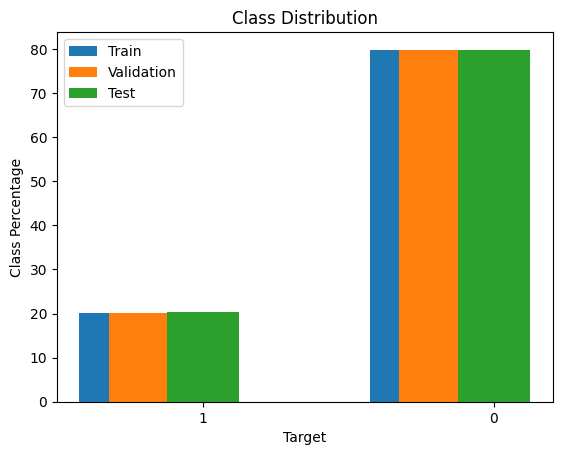

In [ ]:
x = [0,1]
plt.bar(x,[100*sum(y_train)/len(y_train), 100*(len(y_train)-sum(y_train))/len(y_train)],tick_label=['1', '0'],width=0.25, label='Train')
x = list(map(lambda x: x+0.1, x))
plt.bar(x,[100*sum(y_val)/len(y_val), 100*(len(y_val)-sum(y_val))/len(y_val)],tick_label=['1', '0'],width=0.25, label='Validation')
x = list(map(lambda x: x+0.2, x))
plt.bar(x,[100*sum(y_test)/len(y_test), 100*(len(y_test)-sum(y_test))/len(y_test)],tick_label=['1', '0'], label = 'Test',width=0.25)
plt.xlabel('Target')
plt.ylabel('Class Percentage')
plt.title('Class Distribution')
plt.legend();

In [ ]:
print('Train set shape:' , X_train.shape, y_train.shape)
print('Validation set shape:', X_val.shape, y_val.shape)
print('Test set shape:', X_test.shape, y_test.shape)

Train set shape: (444765, 21) (444765,)
Validation set shape: (55596, 21) (55596,)
Test set shape: (55596, 21) (55596,)


In [ ]:
X_train.head()

,product,sub_product,issue,sub_issue,company_public_response,company,state,tags,consumer_consent_provided,submitted_via,...,timely_response,response_time_in_days,month_received,month_sent,year_received,year_sent,latitude,longitude,negative_sentiment,neutral_sentiment
429965,Mortgage,Other mortgage,"Loan modification,collection,foreclosure","Loan modification,collection,foreclosure",Company response unknown,"Seterus, Inc.",MI,Tag unknown,Consent unknown,Postal mail,...,Yes,1,8,8,2012,2012,42.2768,-83.2606,0.37804,0.608346
468819,Mortgage,Conventional fixed mortgage,"Loan servicing, payments, escrow account","Loan servicing, payments, escrow account",Company response unknown,"Seterus, Inc.",FL,Tag unknown,Consent unknown,Web,...,Yes,0,4,4,2014,2014,28.8013,-81.2850,0.37804,0.608346
291455,Mortgage,Reverse mortgage,"Loan servicing, payments, escrow account","Loan servicing, payments, escrow account",Company response unknown,CIT Bank National Association,FL,Tag unknown,Consent unknown,Referral,...,Yes,0,4,4,2012,2012,28.2129,-82.6807,0.37804,0.608346
322801,Mortgage,Conventional fixed mortgage,Credit decision / Underwriting,Credit decision / Underwriting,Company chooses not to provide a public response,Regions Financial Corporation,TN,Tag unknown,Consent not provided,Web,...,Yes,4,11,11,2015,2015,35.0551,-89.6767,0.37804,0.608346
72187,Mortgage,Conventional fixed mortgage,"Loan servicing, payments, escrow account","Loan servicing, payments, escrow account",Company response unknown,Ditech Financial LLC,AZ,Tag unknown,Consent not provided,Web,...,Yes,4,5,5,2015,2015,33.3160,-112.0669,0.37804,0.608346


### Encoding categorical columns

In [ ]:
def ohe_transform_func(X):
    '''
    The function takes an input X, which represents the data to be transformed

    The function returns three values:
    X_transform: which represents the transformed data,
    X_transformer: which represents the fitted transformer object, and
    feature_names: which returns the feature names generated by the transformer.
    '''
    # making a list of numerical columns that don't need any transformation
    numerical_columns = X.select_dtypes(include = np.number).columns.values
    # making a list of nominal columns that need transformation using one hot encoding technique
    categorical_columns = [col for col in X.columns.values if col not in numerical_columns]

    # using OHE to convert nominal values to numerical
    # dropping the first OHE column for each categorical feature because it is redundant
    ohe = OneHotEncoder(drop = 'first', handle_unknown = 'ignore')
    # creating a transformer object that performs transformations on specified columns
    features = ColumnTransformer([('categorical', ohe, categorical_columns), ('passthrough','passthrough',numerical_columns)],verbose_feature_names_out=False)
    # creating a Pipeline object that takes a transformer object as input
    transformer = Pipeline([('features',features)])
    # fitting the transformer on the data
    X_transformer = transformer.fit(X)
    # transforming the input data
    X_transform = X_transformer.transform(X)
    # generating new featrue names after OHE
    feature_names = transformer.named_steps['features'].get_feature_names_out()

    return X_transform, X_transformer, feature_names

In [ ]:
X_train['state'] = X_train['state'].values.astype(str)
X_val['state'] = X_val['state'].values.astype(str)
X_test['state'] = X_test['state'].values.astype(str)

In [ ]:
# applying OHE on the train dataset and
# returning the transformed dataset, transformer obejct and feature names
X_train_transformed, X_transformer, feat_names = ohe_transform_func(X_train)
print('shape of input data after one hot encoding: ', X_train_transformed.shape)

shape of input data after one hot encoding:  (444765, 3822)


In [ ]:
# encoding test data using transformer fitted on train data
X_val_transformed = X_transformer.transform(X_val)

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [ ]:
# encoding test data using transformer fitted on train data
X_test_transformed = X_transformer.transform(X_test)

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


### Feature scaling

In [ ]:
def normalization(X):
    '''
    The function takes an input X, which represents the data to be scaled

    The function returns two values:
    X_transform: which represents the scaled data,
    X_transformer: which represents the fitted max absolute scaling transformer object, and
    '''
    # Define the columns that will be passed through for scaling
    # passthrough_columns = X.columns.values
    features = ColumnTransformer([('passthrough','passthrough', [i for i in range(0, X.shape[1])])])
    # Create a Pipeline object to chain multiple transformers together
    transformer = Pipeline([('features',features), ('scaling', MaxAbsScaler())])
    # fitting the scaling transformer on the dataset
    X_transformer = transformer.fit(X)
    # applying the scaling on the dataset
    X_transform = X_transformer.transform(X)

    return X_transform, X_transformer

In [ ]:
# let's normalizae the training set
X_train_norm, X_train_normalizer = normalization(X_train_transformed)
X_train_norm.shape

(444765, 3822)

In [ ]:
# normalizing test data using transformer fitted on train data
X_val_norm = X_train_normalizer.transform(X_val_transformed)

In [ ]:
# normalizing test data using transformer fitted on train data
X_test_norm = X_train_normalizer.transform(X_test_transformed)

In [ ]:
print('final shape of train data:', X_train_norm.shape)
print('final shape of val data:', X_val_norm.shape)
print('final shape of test data:', X_test_norm.shape)
assert X_train_norm.shape[1] == X_val_norm.shape[1] == X_test_norm.shape[1]

final shape of train data: (444765, 3822)
final shape of val data: (55596, 3822)
final shape of test data: (55596, 3822)


## Model training and evaluation

### Class Imbalance
We look at several techniques below to account for class imbalance. One of the techniques is explicitly penalizing models while training when they misclassify the minority class. This is done by giving more weightage to the minority class. Other techniques include creating a balanced training set so that the models have equal number of samples from both classes to train on.
* Unbalanced training:
    * Same weights: The simplest step is to train a model on the training data as it is. This will be our baseline model.
    * Weighted samples: We can also give more weightage to the under-represented class. The weight given to a class is inversely proportional to its proportion in the data.
* Balanced training:
    * Undersampling: We will start with selecting as many negative class samples as the positive class so that both have equal number in the training set.
    * Oversampling: In this technique, new samples of the minority class are generated by randomly sampling with replacement the current available samples so that both classes have equal representation.
    
### Model Selection
* We short-list 5 ML models in our work:
    * Logistic Regression
    * Support Vector Classifier
    * Random Forest
    * XGBoost
    * Neural network
* We do a crude grid search 5-fold cross-validation with few parameters for all models to select the best model.
* We then do a finer grid search 5-fold cross-validation to fine-tune the best of the 5 models. We select the model with the highest mean ROC AUC.
* Once the final model is selected, we train the model on the entire training set and make predictions on the validation set.
* For final model evaluation, we calculate the following performance measures on the test set:
    * ROC AUC
    * Gini score
    * Precision
    * Recall
    * F1 score
    * F2 score
    * Kolmogorov-Smirnov (KS) score
    * Maximum lift

We repeat the above steps for both balanced and unbalanced training. We find that XGBoost is the best model with the highest ROC AUC in all 4 cases. For the unbalanced case, the weighted class technique performs better since it has better precision, recall, F1 and F2 scores on 5-fold cross validation. For balanced training, undersampling performs slightly better than oversampling (0.6515 vs. 0.6148). Finally, we select the model trained on the undersampled data as our final model since:
  * it is robust to unbalanced data,
  * is computationally efficient since it trains on less data (40% and 25% of unbalanced and oversampled training set respectively),   
  * performs equally well or better as compared to the other 3 learning techniques.

The test set performance of the undersampled model is as follows:
 * 'roc_auc': 0.6469,
 * 'gini': 0.2939,
 * 'ks_score': 0.2118,
 * 'max_lift': 1.7198,
 * 'f1': 0.3855,
 * 'f2': 0.5319,
 * 'precision': 0.2643,
 * 'recall': 0.7122

 Overall, the model does not perform very well on the dataset. Using the following rubric:
* ROC AUC >= 0.90: excellent,
* 0.80 - 0.89: very good,
* 0.70-0.79: fair,
* 0.60-0.69: modest,
* 0.50-0.59: no signal,

the model predicts consumer disputes modestly. The dataset does not contain enough signal to predict disputes. We have oulined some possible complementary information in the executive summary that might help boost the signal for better performance.

### Imbalanced learning: Baseline model

In [ ]:
# let's try out some classifiers
estimators = {'logreg': LogisticRegression(solver = 'saga'),
'svc': LinearSVC(),
'rfc': RandomForestClassifier(),
'xgbc': XGBClassifier(),
'mlp': MLPClassifier(),
}

In [ ]:
# creating grid serach parameters for each single model.
param_grid = {
    'logreg':
    {'C': [0.01, 0.1, 1, 10],
      'penalty': ['l1', 'l2']},

    'svc':
    {'C': [0.1,1,1.0]
    },

    'rfc': {'max_depth': [3, 5],
     'min_samples_leaf': [1, 3],
    'n_estimators': [100, 200]},

    'xgbc': {'max_depth': [2, 5, 10],
     'learning_rate': [0.1, 1., 10.],},

    'mlp':
    {'hidden_layer_sizes': [2,3,5,7]},
    }

In [ ]:
def f2_score(true, pred):
    '''
    This function calculates F2 scores from ground truth and perdictions.
    Args: true: ground truth
        pred: predictions
    Returns: f2: F2 score
    '''
    tn, fp, fn, tp = confusion_matrix(true, pred).ravel()
    p = tp/(tp+fp)
    r = tp/(tp+fn)
    f2 = (5 * p * r) / (4 * p + r)
    return f2

def evaluate_ks(true, pred):
    '''
    Function that calculates the Kolmogorov-Smirnoff score
    Arguments:
        true: ground truth
        pred: predicted probabilities
    '''
    class0 = pred[true == 0]
    class1 = pred[true == 1]

    ks = stats.ks_2samp(class0, class1)
    return ks.statistic

def gini(true, pred):
    '''
    Function that calculates gini score.
    Arguments:
        true: ground truth
        pred: predicted probabilities
    '''
    roc = roc_auc_score(true, pred)
    return 2*roc - 1

def lift(true, pred):
    '''
    Function that calculates maximum lift value.
    Arguments:
        true: ground truth
        pred: predicted probabilities
    '''
    sorted_indices = np.argsort(pred)[::-1]
    n = len(sorted_indices)
    n_decile = n//10
    avg_rate = sum(true)/len(true)

    true = np.array(true)

    deciles = {}
    previous_decile = []
    split_arrays = np.array_split(sorted_indices, 10)
    decile_vals = [true[j] for j in split_arrays[0]]
    pred_rate = sum(decile_vals)/(len(decile_vals))

    return pred_rate/avg_rate

# dictionary containing verious performance metrics
scoring = {
    'roc_auc': 'roc_auc',
    'recall': 'recall',
    'precision': 'precision',
    'f1': 'f1',
    'f2': make_scorer(f2_score),
    'ks_score': make_scorer(evaluate_ks, needs_proba = True),
    'gini': make_scorer(gini, needs_proba = True),
    'max_lift': make_scorer(lift, needs_proba = True)
          }

In [ ]:
def model_testing(X, y, est, estimator):
    '''
    This function performs cross validation for variety of models.
    Args: X: training data
        y: output variable
        estimators: list of estimators
    Returns: est_scores_dict: dictionary containing performance scores from
    models
    '''
    # initialize dictionary containing estimators as keys and perforances scores as output.
    est_scores_dict = {}

    # Get the estimator object
    print(f'Start\n')
    # Record the start time for performance measurement
    start = time.time()
    # Perform cross-validation with the current estimator
    est_scores_dict[est] = cross_validate(estimator, X, y, n_jobs=-1, scoring=scoring);
    # Print a message indicating the completion of processing with the current estimator
    print(f'Finish\n')
    print('Time taken = ', round((time.time() - start)/60.,2) ,'mins \n')

    return est_scores_dict

In [ ]:
def model_score(scores_dict, scoring):
    '''
    This function displays the scores from different classifiers in a
    dataframe.
    Args: scores_dict: Output dictionary from model_testing function
        scoring: dictionary containing various perfomance metrics
    Returns: mean_df: dataframe containing mean scores over k-fold
            cross-validation sets
            std_df: dataframe containing standard deviation scores over k-fold
            cross-validation sets
    '''
    # Create a set of score names with 'test_' prefix
    score_set = {'test_' + score for score in scoring.keys()}
    # Initialize dictionaries to store mean and standard deviation values
    mean_dict = {}
    std_dict = {}

    # Calculate mean and standard deviation for each estimator
    for estimator in scores_dict.keys():
        # Calculate mean for each score in the score set
        mean_dict[estimator] = {score: round(np.mean(scores_dict[estimator][score]),3) for score in score_set}
        # Calculate standard deviation for each score in the score set
        std_dict[estimator] = {score: round(np.std(scores_dict[estimator][score]),3) for score in score_set}

    # Create DataFrames from the mean and standard deviation dictionaries
    mean_df = pd.DataFrame(mean_dict)
    std_df = pd.DataFrame(std_dict)

    return mean_df, std_df

In [ ]:
def best_scores_function(estimator, train_df, y_true, model_score_dict):
    '''
    The function sets up and performs grid search cv for any of the candidate models.
    Args: estimator: single/ensemble estimator
        model_score_dict: dictionary containing ROC AUC scores
    Returns:
        model_score_dict: dictionary containing updated ROC AUC scores
    '''
    # Check if the estimator is a single estimator or an ensemble estimator
    est = estimators[estimator]
    grid_search = GridSearchCV(est, param_grid[estimator], cv = 5, scoring = 'roc_auc', n_jobs=-1, refit=False)

    start = time.time()
    # Fit the grid search based on the estimator type
    grid_search.fit(train_df, y_true);
    print(f'{estimator} Grid Search Time Taken: ', round( (time.time() - start)/60., 3), ' mins')

    # grid search cv results
    est_scores = grid_search.cv_results_
    # Update the model F1 score dictionary with the maximum F1 score
    model_score_dict[estimator] = max(est_scores['mean_test_score'])

    return model_score_dict

In [ ]:
model_score_dict = {}
for est in estimators.keys():
    model_score_dict = best_scores_function(est, X_train_norm, y_train, model_score_dict)

logreg Grid Search Time Taken:  5.807  mins
svc Grid Search Time Taken:  1.517  mins
rfc Grid Search Time Taken:  0.805  mins
xgbc Grid Search Time Taken:  0.213  mins
mlp Grid Search Time Taken:  2.129  mins


In [ ]:
sorted(model_score_dict.items(), key = lambda x: x[1], reverse = True)

[('xgbc', np.float64(0.6465279519731334)),
 ('logreg', np.float64(0.6346433348251761)),
 ('mlp', np.float64(0.6337292173487897)),
 ('svc', np.float64(0.6330235003829449)),
 ('rfc', np.float64(0.6141624211168608))]

In [ ]:
best_model_grid = {'max_depth': [5, 10, 15, None],
     'learning_rate': [ 0.1, 0.5, 1., 5],}
best_model = estimators['xgbc']

In [ ]:
grid_search = GridSearchCV(best_model, best_model_grid, cv = 5, scoring = 'roc_auc', refit=True, n_jobs=-1, return_train_score=True)

In [ ]:
grid_search.fit(X_train_norm, y_train);

In [ ]:
best_est_unbalanced = grid_search.best_estimator_
best_est_unbalanced

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=15,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
scoring_cp = {
    'roc_auc': 'roc_auc',
    'recall': 'recall',
    'precision': 'precision',
    'f1': 'f1',
    'f2': make_scorer(f2_score),
    'ks_score': make_scorer(evaluate_ks, response_method = 'predict_proba'),
    'gini': make_scorer(gini, response_method = 'predict_proba'),
    'max_lift': make_scorer(lift, response_method = 'predict_proba')
          }

In [ ]:
cross_val_scores = {}
cross_val_score = cross_validate(best_est_unbalanced, X_train_norm, y_train, cv=5, scoring = scoring_cp)
cross_val_scores['unbalanced'] = round(np.mean(cross_val_score['test_roc_auc']), 4)

In [ ]:
best_est_unbalanced.fit(X_train_norm, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=15,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
def calculate_metrics(true, prob, pred):
    '''
    Function that calculates various performance metrics.
    Arguments:
        true: ground truth
        prob: predicted probabilities
        pred: predicted output class
    '''
    roc_auc = roc_auc_score(true, prob)
    gini_score = gini(true, prob)
    ks_score = evaluate_ks(true, prob)
    max_lift = lift(true, prob)
    f1 = metrics.f1_score(true, pred)
    f2 = metrics.fbeta_score(true, pred, beta = 2)
    precision = metrics.precision_score(true, pred)
    recall = metrics.recall_score(true, pred)

    scores_dict = {
        'roc_auc': round(roc_auc, 4),
        'gini': round(gini_score, 4),
        'ks_score': round(ks_score, 4),
        'max_lift': round(max_lift, 4),
        'f1': round(f1, 4),
        'f2': round(f2, 4),
        'precision': round(precision, 4),
        'recall': round(recall, 4),
    }

    return scores_dict

In [ ]:
y_prob_unbalanced = best_est_unbalanced.predict_proba(X_val_norm)
y_pred_unbalanced = best_est_unbalanced.predict(X_val_norm)

In [ ]:
positive_class_probs = y_prob_unbalanced[:, 1]
scores_dict = calculate_metrics(y_val, positive_class_probs, y_pred_unbalanced)

val_scores_dict = {
'unbalanced': scores_dict
}

In [ ]:
val_scores_dict

{'unbalanced': {'roc_auc': np.float64(0.6563),
  'gini': np.float64(0.3126),
  'ks_score': np.float64(0.2247),
  'max_lift': np.float64(1.7627),
  'f1': 0.0235,
  'f2': 0.0149,
  'precision': 0.6233,
  'recall': 0.012}}

### Class weights

In [ ]:
num_classes = 2
w_0 = len(y_train)/(num_classes*(len(y_train[y_train == 0])))
w_1 = len(y_train)/(num_classes*(len(y_train[y_train == 1])))
sample_weight = np.array([w_0 if val == 0 else w_1 for val in y_train])

In [ ]:
# let's try out some classifiers
weight_estimators = {'logreg': LogisticRegression(solver = 'saga', class_weight='balanced'),
'svc': LinearSVC(class_weight='balanced'),
'rfc': RandomForestClassifier(class_weight='balanced'),
'xgbc': XGBClassifier(scale_pos_weight = w_1/w_0),
}

In [ ]:
model_score_dict = {}
for est in weight_estimators.keys():
    model_score_dict = best_scores_function(est, X_train_norm, y_train, model_score_dict)

logreg Grid Search Time Taken:  5.674  mins
svc Grid Search Time Taken:  1.496  mins
rfc Grid Search Time Taken:  0.799  mins
xgbc Grid Search Time Taken:  0.227  mins


In [ ]:
sorted(model_score_dict.items(), key = lambda x: x[1], reverse = True)

[('xgbc', np.float64(0.6465279519731334)),
 ('logreg', np.float64(0.6346434083198792)),
 ('svc', np.float64(0.6330235003829449)),
 ('rfc', np.float64(0.6127764603082806))]

In [ ]:
best_model_grid = {'max_depth': [5, 10, 15, None],
     'learning_rate': [ 0.1, 0.5, 1., 5],}
best_model = weight_estimators['xgbc']

In [ ]:
grid_search = GridSearchCV(best_model, best_model_grid, cv = 5, scoring = 'roc_auc', refit=True, n_jobs=-1, return_train_score=True)

In [ ]:
grid_search.fit(X_train_norm, y_train);

In [ ]:
best_est_weighted = grid_search.best_estimator_
best_est_weighted

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
cross_val_score = cross_validate(best_est_weighted, X_train_norm, y_train, cv=5, scoring = scoring_cp)
cross_val_scores['unbalanced_weight'] = round(np.mean(cross_val_score['test_roc_auc']), 4)

In [ ]:
best_est_weighted.fit(X_train_norm, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
y_prob_weighted = best_est_weighted.predict_proba(X_val_norm)
y_pred = best_est_weighted.predict(X_val_norm)
positive_class_probs = y_prob_weighted[:, 1]
scores_dict = calculate_metrics(y_val, positive_class_probs, y_pred)

val_scores_dict['weighted'] = scores_dict

### Balanced learning

#### Undersampling

In [ ]:
rus = RandomUnderSampler(random_state = 42)
X_undersampled, y_undersampled = rus.fit_resample(X_train, y_train)

In [ ]:
X_undersampled.head()

,product,sub_product,issue,sub_issue,company_public_response,company,state,tags,consumer_consent_provided,submitted_via,company_response_to_consumer,timely_response,response_time_in_days,month_received,month_sent,year_received,year_sent,latitude,longitude,negative_sentiment,neutral_sentiment
283974,Mortgage,Conventional fixed mortgage,"Loan servicing, payments, escrow account","Loan servicing, payments, escrow account",Company response unknown,"Seterus, Inc.",FL,"Older American, Servicemember",Consent unknown,Phone,Closed with explanation,Yes,0,3,3,2016,2016,27.8170,-82.6264,0.37804,0.608346
215772,Debt collection,Credit card,Communication tactics,Threatened to take legal action,Company response unknown,ERC,TX,Older American,Consent unknown,Postal mail,Closed with non-monetary relief,Yes,6,5,5,2015,2015,30.5052,-97.8203,0.37804,0.608346
178605,Mortgage,FHA mortgage,"Loan modification,collection,foreclosure","Loan modification,collection,foreclosure",Company response unknown,The Huntington National Bank,OH,Tag unknown,Consent unknown,Phone,Closed with explanation,Yes,7,1,1,2016,2016,41.4335,-81.6323,0.37804,0.608346
486754,Mortgage,Other mortgage,"Loan modification,collection,foreclosure","Loan modification,collection,foreclosure",Company response unknown,Ocwen,GA,Tag unknown,Consent unknown,Referral,Closed without relief,Yes,1,3,3,2012,2012,33.8769,-83.8968,0.37804,0.608346
215124,Consumer Loan,Vehicle loan,Managing the loan or lease,Managing the loan or lease,Company response unknown,Wells Fargo & Company,CA,Tag unknown,Consent unknown,Referral,Closed with explanation,No,1,1,1,2014,2014,34.2619,-118.5820,0.37804,0.608346


In [ ]:
X_undersampled.shape

(179338, 21)

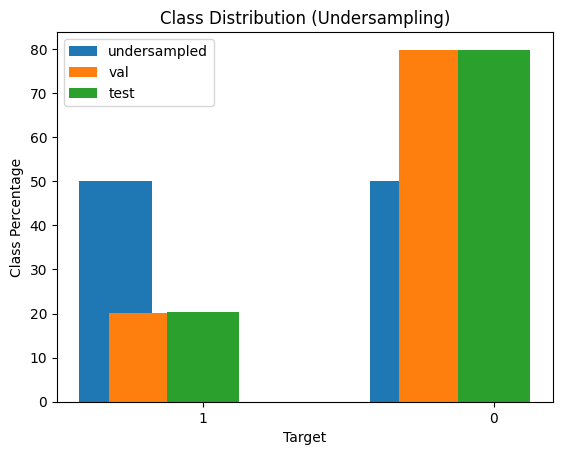

In [ ]:
# See how the data will look after applying the random under sampler.
# We'll keep the class imbalance in the test set because
# that is reflective of the true distribution.
x = [0,1]
plt.bar(x,[100*sum(y_undersampled)/len(y_undersampled), 100*(1-sum(y_undersampled)/len(y_undersampled))],tick_label=['1', '0'],label='undersampled', width = 0.25)
x = list(map(lambda x: x+0.1, x))
plt.bar(x,[100*sum(y_val)/len(y_val), 100*(1-sum(y_val)/len(y_val))],tick_label=['1', '0'],label='val', width = 0.25)
x = list(map(lambda x: x+0.2, x))
plt.bar(x,[100*sum(y_test)/len(y_test), 100*(1-sum(y_test)/len(y_test))],tick_label=['1', '0'],label='test', width = 0.25)
plt.xlabel('Target')
plt.ylabel('Class Percentage')
plt.title('Class Distribution (Undersampling)')
plt.legend();

In [ ]:
def transform_train_test(train, val, test):
    '''
    Function that performs OHE and normalization of train and test sets.
    Arguments:
        train: train data
        test: test data
    '''

    X_train_transformed, X_transformer, feat_names = ohe_transform_func(train)

    # encoding val data using transformer fitted on train data
    X_val_transformed = X_transformer.transform(val)
    # encoding test data using transformer fitted on train data
    X_test_transformed = X_transformer.transform(test)

    # let's normalizae the training set
    X_train_norm, X_train_normalizer = normalization(X_train_transformed)
    # converting normalized training data matrix to dataframe

    # normalizing val data using transformer fitted on train data
    X_val_norm = X_train_normalizer.transform(X_val_transformed)
    # normalizing test data using transformer fitted on train data
    X_test_norm = X_train_normalizer.transform(X_test_transformed)

    return X_train_norm, X_val_norm, X_test_norm

In [ ]:
X_undersampled['state'] = X_undersampled['state'].values.astype(str)

In [ ]:
X_train_norm, X_val_norm, X_test_norm = transform_train_test(X_undersampled, X_val, X_test)

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [3, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [ ]:
model_score_dict = {}
for est in estimators.keys():
    model_score_dict = best_scores_function(est, X_train_norm, y_undersampled, model_score_dict)

logreg Grid Search Time Taken:  1.703  mins
svc Grid Search Time Taken:  0.293  mins
rfc Grid Search Time Taken:  0.289  mins
xgbc Grid Search Time Taken:  0.101  mins
mlp Grid Search Time Taken:  1.485  mins


In [ ]:
sorted(model_score_dict.items(), key = lambda x: x[1], reverse = True)

[('xgbc', np.float64(0.6427654290995967)),
 ('logreg', np.float64(0.6335094238827577)),
 ('svc', np.float64(0.6325544572049552)),
 ('mlp', np.float64(0.6299447573161548)),
 ('rfc', np.float64(0.6132490435959698))]

In [ ]:
best_model_grid = {'max_depth': [5, 10, 15, None],
     'learning_rate': [ 0.1, 0.5, 1., 5],}
best_model = estimators['xgbc']

In [ ]:
grid_search = GridSearchCV(best_model, best_model_grid, cv = 5, scoring = 'roc_auc', refit=True, n_jobs=-1, return_train_score=True)

In [ ]:
grid_search.fit(X_train_norm, y_undersampled);

In [ ]:
best_est_undersampled = grid_search.best_estimator_
best_est_undersampled

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
cross_val_score = cross_validate(best_est_undersampled, X_train_norm, y_undersampled, cv=5, scoring = scoring_cp)
cross_val_scores['undersampling'] = round(np.mean(cross_val_score['test_roc_auc']), 4)

In [ ]:
best_est_undersampled.fit(X_train_norm, y_undersampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
y_prob_undersampled = best_est_undersampled.predict_proba(X_val_norm)
y_pred_undersampled = best_est_undersampled.predict(X_val_norm)
positive_class_probs = y_prob_undersampled[:, 1]
scores_dict = calculate_metrics(y_val, positive_class_probs, y_pred_undersampled)

val_scores_dict['undersampled'] = scores_dict

#### Oversampling

In [ ]:
ros = RandomOverSampler(random_state = 42)
X_oversampled, y_oversampled = ros.fit_resample(X_train, y_train)

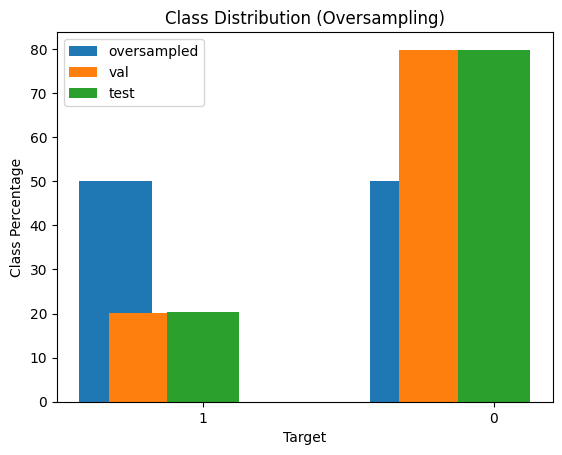

In [ ]:
# See how the data will look after applying the random under sampler.
# We'll keep the class imbalance in the test set because
# that is reflective of the true distribution.
x = [0,1]
plt.bar(x,[100*sum(y_oversampled)/len(y_oversampled), 100*(1-sum(y_oversampled)/len(y_oversampled))],tick_label=['1', '0'],label='oversampled', width = 0.25)
x = list(map(lambda x: x+0.1, x))
plt.bar(x,[100*sum(y_val)/len(y_val), 100*(1-sum(y_val)/len(y_val))],tick_label=['1', '0'],label='val', width = 0.25)
x = list(map(lambda x: x+0.2, x))
plt.bar(x,[100*sum(y_test)/len(y_test), 100*(1-sum(y_test)/len(y_test))],tick_label=['1', '0'],label='test', width = 0.25)
plt.xlabel('Target')
plt.ylabel('Class Percentage')
plt.title('Class Distribution (Oversampling)')
plt.legend();

In [ ]:
X_oversampled['state'] = X_oversampled['state'].values.astype(str)

In [ ]:
X_train_norm, X_val_norm, X_test_norm = transform_train_test(X_oversampled, X_val, X_test)

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [ ]:
X_train_norm.shape

(710192, 3822)

In [ ]:
model_score_dict = {}
for est in estimators.keys():
    model_score_dict = best_scores_function(est, X_train_norm, y_oversampled, model_score_dict)

logreg Grid Search Time Taken:  9.473  mins
svc Grid Search Time Taken:  2.957  mins
rfc Grid Search Time Taken:  1.323  mins
xgbc Grid Search Time Taken:  0.317  mins
mlp Grid Search Time Taken:  2.842  mins


In [ ]:
sorted(model_score_dict.items(), key = lambda x: x[1], reverse = True)

[('xgbc', np.float64(0.7234409068702506)),
 ('mlp', np.float64(0.6631189584444833)),
 ('svc', np.float64(0.6440802226480689)),
 ('logreg', np.float64(0.6439868239841354)),
 ('rfc', np.float64(0.6161315513112926))]

In [ ]:
best_model_grid = {'max_depth': [5, 10, 15, None],
     'learning_rate': [ 0.1, 0.5, 1., 5],}
best_model = estimators['xgbc']

In [ ]:
grid_search = GridSearchCV(best_model, best_model_grid, cv = 5, scoring = 'roc_auc', refit=True, n_jobs=-1, return_train_score=True)

In [ ]:
grid_search.fit(X_train_norm, y_oversampled);

In [ ]:
best_est_oversampled = grid_search.best_estimator_
best_est_oversampled

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=1.0, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=15,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
cross_val_score = cross_validate(best_est_oversampled, X_train_norm, y_oversampled, cv=5, scoring = scoring_cp)
cross_val_scores['oversampling'] = round(np.mean(cross_val_score['test_roc_auc']), 4)

In [ ]:
best_est_oversampled.fit(X_train_norm, y_oversampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=1.0, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=15,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
y_prob_oversampled = best_est_oversampled.predict_proba(X_val_norm)
y_pred_oversampled = best_est_oversampled.predict(X_val_norm)
positive_class_probs = y_prob_oversampled[:, 1]
scores_dict = calculate_metrics(y_val, positive_class_probs, y_pred_oversampled)

val_scores_dict['oversampled'] = scores_dict

In [ ]:
val_scores_df = pd.DataFrame.from_dict(val_scores_dict, orient = 'index')
val_scores_df.head()

,roc_auc,gini,ks_score,max_lift,f1,f2,precision,recall
unbalanced,0.6563,0.3126,0.2247,1.7627,0.0235,0.0149,0.6233,0.0120
weighted,0.6536,0.3072,0.2229,1.7244,0.3901,0.5355,0.2686,0.7124
undersampled,0.6515,0.3030,0.2171,1.7208,0.3869,0.5338,0.2653,0.7146
oversampled,0.6148,0.2296,0.1663,1.5745,0.3497,0.4237,0.2708,0.4934


## Model selection

In [ ]:
val_scores_df = pd.DataFrame.from_dict(val_scores_dict, orient = 'index')
val_scores_df.head()

,roc_auc,gini,ks_score,max_lift,f1,f2,precision,recall
unbalanced,0.6563,0.3126,0.2247,1.7627,0.0235,0.0149,0.6233,0.0120
weighted,0.6536,0.3072,0.2229,1.7244,0.3901,0.5355,0.2686,0.7124
undersampled,0.6515,0.3030,0.2171,1.7208,0.3869,0.5338,0.2653,0.7146
oversampled,0.6148,0.2296,0.1663,1.5745,0.3497,0.4237,0.2708,0.4934


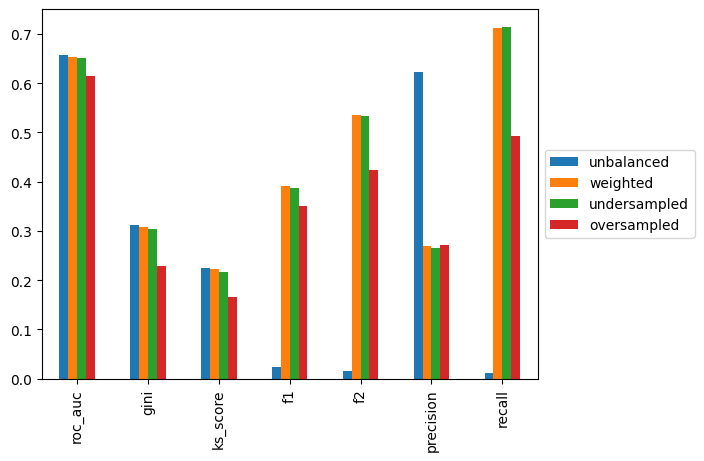

In [ ]:
val_scores_df.drop(columns=['max_lift']).T.plot.bar()
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5));

## Saving the best model

In [ ]:
X_train_transformed, X_transformer, feat_names = ohe_transform_func(X_undersampled)
X_train_norm, X_train_normalizer = normalization(X_train_transformed)

In [ ]:
with open(f'{get_cwd}/saved_model/model.pkl', 'wb') as f:
  pickle.dump(best_est_undersampled, f)

with open(f'{get_cwd}/saved_model/ohe_transformer.pkl', 'wb') as f:
  pickle.dump(X_transformer, f)

with open(f'{get_cwd}/saved_model/normalizer.pkl', 'wb') as f:
  pickle.dump(X_train_normalizer, f)

with open(f'{get_cwd}/saved_model/feat_names.pkl', 'wb') as f:
  pickle.dump(feat_names, f)

## Further visualizations

In [ ]:
X_train_norm, X_val_norm, X_test_norm = transform_train_test(X_undersampled, X_val, X_test)

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [3, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [ ]:
y_test_prob_undersampled = best_est_undersampled.predict_proba(X_test_norm)
y_test_pred_undersampled = best_est_undersampled.predict(X_test_norm)
positive_class_probs = y_test_prob_undersampled[:, 1]
test_scores_dict = calculate_metrics(y_test, positive_class_probs, y_test_pred_undersampled)

In [ ]:
test_scores_dict

{'roc_auc': np.float64(0.6469),
 'gini': np.float64(0.2939),
 'ks_score': np.float64(0.2118),
 'max_lift': np.float64(1.7198),
 'f1': 0.3855,
 'f2': 0.5319,
 'precision': 0.2643,
 'recall': 0.7122}

In [ ]:
def lift_chart(true, pred, n_splits = 10):
    '''
    Function that creates data points (x = sample proportion, y = lift values) for plotting lift curve.
    Arguments:
        true: ground truth
        pred: predicted probabilities
        n_splits: number of splits to be created in the sample
    '''
    sorted_indices = np.argsort(pred)[::-1]
    avg_rate = sum(true)/len(true)

    true = np.array(true)

    lift_vals = {}
    previous_decile = []
    split_arrays = np.array_split(sorted_indices, n_splits)
    composition = np.array([])
    for i, current in enumerate(split_arrays):
        decile_vals = [true[j] for j in current]
        decile_vals = np.concatenate((decile_vals, composition), axis=None)
        pred_rate = sum(decile_vals)/(len(decile_vals))
        lift_vals[i + 1] = pred_rate/avg_rate
        composition = decile_vals

    return lift_vals

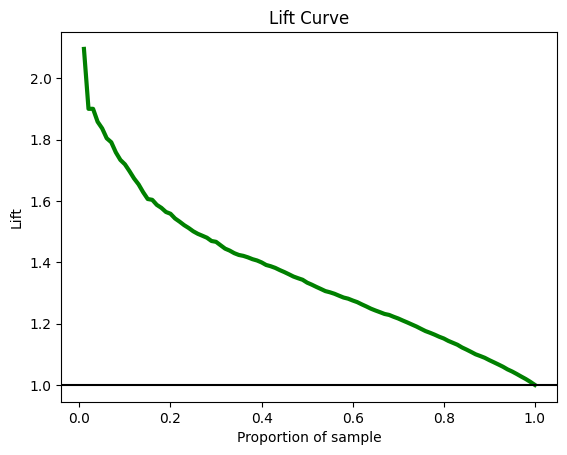

In [ ]:
n_splits = 100
lift_values = lift_chart(y_test, y_test_prob_undersampled[:,1], n_splits)
x = sorted(lift_values.keys())
y = [lift_values[i] for i in x]
plt.plot([val/n_splits for val in x], y, 'g-', linewidth = 3, markersize = 5)
plt.axhline(1, color = 'black')
plt.xlabel('Proportion of sample')
plt.ylabel('Lift')
plt.title('Lift Curve');

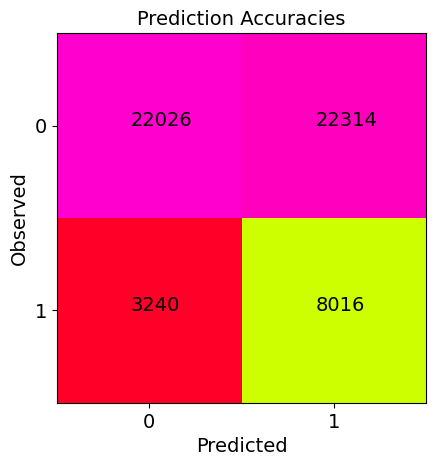

In [ ]:
cm = confusion_matrix(y_test, y_test_pred_undersampled, labels=[0, 1])
plt.imshow(cm, cmap=plt.cm.gist_rainbow)
plt.xticks(ticks=[0, 1], labels=['0', '1'], fontsize=14)
plt.yticks(ticks=[0, 1], labels=['0', '1'], fontsize=14)
plt.ylabel('Observed', fontsize=14)
plt.xlabel('Predicted', fontsize=14)
plt.text(-0.1,0,round(cm[0,0]), fontsize=14)
plt.text(0.9,0,round(cm[0,1]), fontsize=14)
plt.text(-0.1,1,round(cm[1,0]), fontsize=14)
plt.text(0.9,1,round(cm[1,1]), fontsize=14)
plt.title('Prediction Accuracies', fontsize=14);

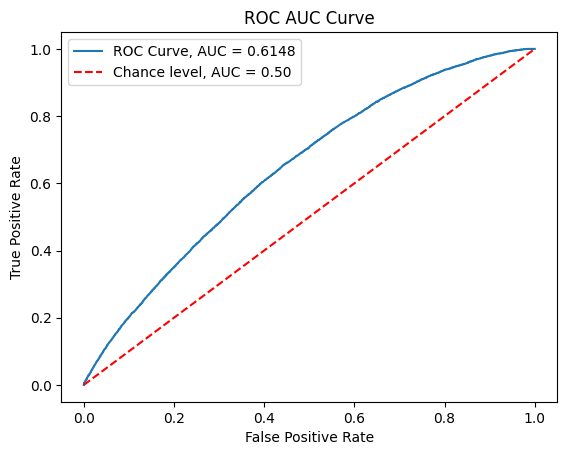

In [ ]:
fpr, tpr, threshold = roc_curve(y_test, y_test_prob_undersampled[:, 1])
plt.plot(fpr, tpr, label = f'ROC Curve, AUC = {round(scores_dict["roc_auc"], 4)}')
plt.plot([0, 1], [0, 1],'r--', label = 'Chance level, AUC = 0.50')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC AUC Curve')
plt.legend();

# FEATURE IMPORTANCES

Let's also look at some important features that are important for predictive modeling and distinguish between the two classes in our dataset.

Key takeaways:
* We find that `company_response_to_consumer` values were most important in our classification model. The second most important feature was `product`, the most important being Credit Reporting and Debt Collection.
* The findings in this section are in agreement with the univariate analysis earlier where `company_response_to_consumer` was also the most important feature distinguishing between disputes and non-disputes.

In [ ]:
# looking at top 10 features
feature_importances_ind = np.argsort(best_est_undersampled.feature_importances_)[::-1]
feature_importances_ind[:10]

array([3004, 3000,    2, 3005, 2999, 3006,    3, 2449,    5, 1099])

In [ ]:
_, _, feat_names = ohe_transform_func(X_undersampled)

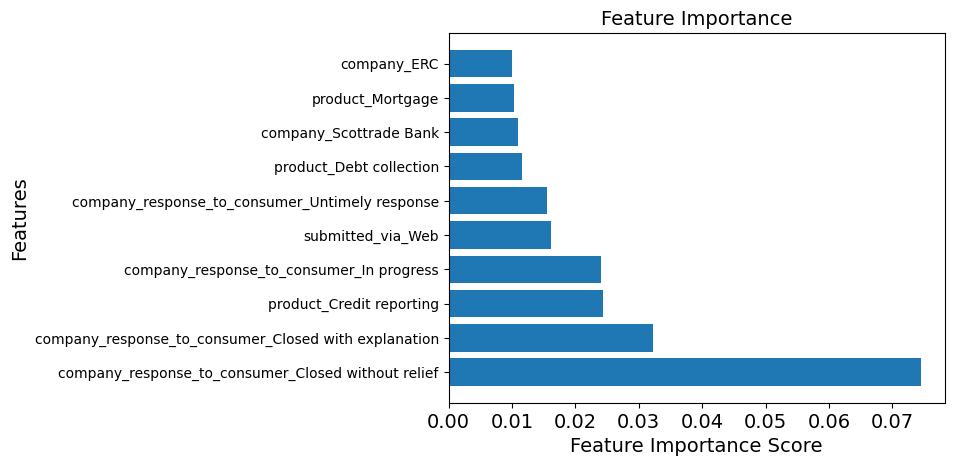

In [ ]:
top_10_features = feature_importances_ind[:10]
plt.barh(feat_names[top_10_features], best_est_undersampled.feature_importances_[top_10_features])
plt.xlabel('Feature Importance Score', fontsize = 14)
plt.ylabel('Features', fontsize = 14)
plt.title('Feature Importance', fontsize = 14)
plt.xticks(fontsize = 14);